In [1]:
pip install torch

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install torch_geometric

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [107]:
%%capture
!kaggle datasets download -d vitvhong/uplink
!unzip uplink.zip -d ./uplink
%cd uplink

In [3]:
import numpy as np
import torch
from torch_geometric.loader import  DataLoader
from torch_geometric.data import HeteroData, Data, Dataset, Batch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
import torch.nn as nn
from torch.nn import Sequential as Seq, Linear as Lin, ReLU, ELU, Sigmoid, BatchNorm1d as BN, ReLU6 as ReLU6
import scipy.io
from torch_geometric.nn import HeteroConv, SAGEConv
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
import matplotlib.pyplot as plt

In [4]:
train_layouts = 10000
test_layouts = 1000

In [5]:
data = scipy.io.loadmat('cf_train_6_30_2.mat')
beta_train = data['betas'][:train_layouts]
direct_train = data['directs'][:train_layouts]
cross_train = data['corsses'][:train_layouts].transpose(0,2,1)

In [6]:
test_data = scipy.io.loadmat('cf_test_6_30_2.mat')
beta_test = test_data['betas'][:test_layouts]
direct_test = test_data['directs'][:test_layouts]
cross_test = test_data['corsses'][:test_layouts].transpose(0,2,1)

In [7]:
def normalize_data(train_data,test_data):
    train_mean = np.mean(train_data)
    train_std = np.std(train_data)
    norm_train = (train_data)/train_std
    norm_test = (test_data)/train_std
    n1, n2 = norm_train.shape[0], norm_test.shape[0]
    return norm_train, norm_test
norm_train_losses, norm_test_losses = normalize_data(beta_train**(1/2), beta_test**(1/2) )

In [8]:
## For GNNs, we allow train_K \neq test_K
train_K, train_M = beta_train.shape[2], beta_train.shape[1]
test_K, test_M = beta_test.shape[2], beta_test.shape[1]

In [9]:
class PCDataset(Dataset):
    def __init__(self, norm_losses, direct, cross, KM):
        self.norm_losses = norm_losses
        self.direct = torch.tensor(direct, dtype=torch.float)
        self.cross = torch.tensor(cross, dtype=torch.float)
        self.KM = KM
        self.get_cg()
        self.process()

    def build_graph(self, idx):
        edge_feature = self.norm_losses[idx, :, :].reshape((self.KM[0] * self.KM[1], 1), order='F')
        edge_feature = np.concatenate((edge_feature, np.ones_like(edge_feature)), axis=-1)
        edge_feature = torch.tensor(edge_feature, dtype=torch.float)

        edge_index = torch.tensor(self.adj, dtype=torch.long).t().contiguous()
        edge_index_t = torch.tensor(self.adj_t, dtype=torch.long).t().contiguous()
        ue_features = torch.ones((self.KM[0], 1))
        ap_features = torch.ones((self.KM[1], 1))

        data = HeteroData()
        data['UE'].x = ue_features
        data['AP'].x = ap_features
        data['UE', 'com-by', 'AP'].edge_index = edge_index
        data['UE', 'com-by', 'AP'].edge_attr = edge_feature
        data['AP', 'com', 'UE'].edge_index = edge_index_t
        data['AP', 'com', 'UE'].edge_attr = edge_feature

        return data

    def get_cg(self):
        self.adj = []
        self.adj_t = []
        for i in range(self.KM[0]):
            for j in range(self.KM[1]):
                self.adj.append([i, j])
                self.adj_t.append([j, i])

    def process(self):
        self.graph_list = [self.build_graph(i) for i in range(len(self.direct))]

    def __len__(self):
        return len(self.direct)

    def __getitem__(self, index):
        return self.graph_list[index], self.direct[index], self.cross[index]

In [10]:
def collate(samples):
    '''Pytorch Geometric collate function'''
    graphs, direct, cross = map(list, zip(*samples))
    batched_graph = Batch.from_data_list(graphs)
    return batched_graph, torch.stack(direct), torch.stack(cross)

In [11]:
train_data = PCDataset(norm_train_losses, direct_train, cross_train, (train_K, train_M))
test_data = PCDataset(norm_test_losses, direct_test, cross_test, (test_K, test_M))

In [12]:
norm_test_losses.shape

(1000, 30, 6)

# Mục mới

In [12]:
batch_size = 64
train_loader = DataLoader(train_data, batch_size, shuffle=True, collate_fn=collate)
test_loader = DataLoader(test_data, 1000, shuffle=False, collate_fn=collate)

In [13]:
def rate_loss(allocs, directlink_channel_losses, crosslink_channel_losses, test_mode = False):
    SINRs_numerators = allocs * directlink_channel_losses**2
    SINRs_denominators = torch.squeeze(torch.matmul(crosslink_channel_losses, torch.unsqueeze(allocs, axis=-1))) + directlink_channel_losses
    SINRs = SINRs_numerators / SINRs_denominators
    rates = torch.log2(1 + SINRs)
    min_rate = torch.min(rates, dim = 1)[0] # take min
    if test_mode:
        return min_rate
    else:
        return -torch.mean(min_rate)

In [14]:
def MLP(channels, batch_norm=True):
    return Seq(*[
        Seq(Lin(channels[i - 1], channels[i]), ReLU(), BN(channels[i]))
        for i in range(1, len(channels))
    ])
class EdgeConv(MessagePassing):
    def __init__(self, input_dim, node_dim, **kwargs):
        super(EdgeConv, self).__init__(aggr='mean')  # mean aggregation
        self.lin = MLP([input_dim, 32])
        self.res_lin = Lin(node_dim, 32)
        self.bn = BN(32)

    def forward(self, x, edge_index, edge_attr):

        feat_src, feat_dst = x


        out = self.propagate(edge_index=edge_index, x=(feat_src, feat_dst), edge_attr=edge_attr)


        return self.bn(out + self.res_lin(feat_dst))

    def message(self, x_j, x_i, edge_attr):
        # Tạo ra thông điệp từ các nút nguồn, nút đích và đặc tính cạnh
        out = torch.cat([x_j, x_i, edge_attr], dim=1)
        return self.lin(out)

    def update(self, aggr_out):
        # Cập nhật giá trị nút đích sau khi tập hợp
        return aggr_out



In [15]:
class RGCN(nn.Module):
    def __init__(self):
        super(RGCN, self).__init__()
        self.conv1 = HeteroConv({
            ('UE', 'com-by', 'AP'): EdgeConv(4, 1),
            ('AP', 'com', 'UE'): EdgeConv(4, 1)
        }, aggr='mean')

        self.conv2 = HeteroConv({
            ('UE', 'com-by', 'AP'): EdgeConv(66, 32),
            ('AP', 'com', 'UE'): EdgeConv(66, 32)
        }, aggr='mean')

        self.conv3 = HeteroConv({
            ('UE', 'com-by', 'AP'): EdgeConv(66, 32),
            ('AP', 'com', 'UE'): EdgeConv(66, 32)
        }, aggr='mean')

        self.mlp = MLP([32, 16])
        self.mlp = nn.Sequential(*[self.mlp, Seq(Lin(16, 1), Sigmoid())])

    def forward(self,x_dict, edge_index_dict, edge_attr_dict):
        out = self.conv1(x_dict, edge_index_dict, edge_attr_dict)
        out = self.conv2(out, edge_index_dict, edge_attr_dict)
        out = self.conv3(out, edge_index_dict, edge_attr_dict)
        out = self.mlp(out['UE'])
        return out


In [25]:
model = RGCN()
optimizer = torch.optim.Adam(model.parameters(), lr=7e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.52)

In [22]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 14593


In [18]:
def train_model(epoch, model, optimizer, train_loader):
    """ Train for one epoch. """
    model.train()
    loss_all = 0
    for batch_idx, (data, d_train, c_train) in enumerate(train_loader):
        K = d_train.shape[-1]
        n = len(data['UE'].x)
        bs = len(data['UE'].x) // K

        optimizer.zero_grad()

        # Lấy các đặc trưng nút từ từ điển x_dict
        user_feats = data['AP'].x
        item_feats = data['UE'].x
        node_features = {'AP': user_feats, 'UE': item_feats}

        # Truyền qua mô hình, bao gồm cả edge_attr_dict
        output = model(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)

        # Tính loss và thực hiện backpropagation
        loss = rate_loss(output, d_train, c_train)
        loss.backward()

        loss_all += loss.item() * bs
        optimizer.step()

    return loss_all / len(train_loader.dataset)

def test_model(loader, model):
    model.eval()
    correct = 0
    with torch.no_grad():
        for (data, d_test, c_test) in loader:
            K = d_test.shape[-1]
            n = len(data['UE'].x)
            bs = len(data['UE'].x) // K

            # Lấy các đặc trưng nút từ từ điển x_dict
            user_feats = data['AP'].x
            item_feats = data['UE'].x
            # Create a dictionary for node features
            node_features = {'AP': user_feats, 'UE': item_feats}

            output = model(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)

            # Tính loss
            loss = rate_loss(output, d_test, c_test)
            correct += loss.item() * bs

    return correct / len(loader.dataset)

In [26]:
record_gnn = []

for epoch in range(0, 100):
    if epoch % 1 == 0:
        with torch.no_grad():
            test_rate = test_model(test_loader, model)
            train_rate = test_model(train_loader, model)
        print(f'Epoch {epoch:03d}, Train Rate: {train_rate:.4f}, Test Rate: {test_rate:.4f}')
        record_gnn.append([train_rate, test_rate])

    train_model(epoch, model, optimizer, train_loader )
    scheduler.step()


Epoch 000, Train Rate: -0.2342, Test Rate: -0.2579
Epoch 001, Train Rate: -0.4402, Test Rate: -0.4522
Epoch 002, Train Rate: -0.5473, Test Rate: -0.5567
Epoch 003, Train Rate: -0.5699, Test Rate: -0.5782
Epoch 004, Train Rate: -0.5927, Test Rate: -0.5984
Epoch 005, Train Rate: -0.6007, Test Rate: -0.6059
Epoch 006, Train Rate: -0.6199, Test Rate: -0.6218
Epoch 007, Train Rate: -0.5806, Test Rate: -0.5828
Epoch 008, Train Rate: -0.5508, Test Rate: -0.5559
Epoch 009, Train Rate: -0.6008, Test Rate: -0.6058
Epoch 010, Train Rate: -0.6027, Test Rate: -0.6050
Epoch 011, Train Rate: -0.6350, Test Rate: -0.6379
Epoch 012, Train Rate: -0.6355, Test Rate: -0.6381
Epoch 013, Train Rate: -0.6352, Test Rate: -0.6386
Epoch 014, Train Rate: -0.6541, Test Rate: -0.6566
Epoch 015, Train Rate: -0.6042, Test Rate: -0.6085
Epoch 016, Train Rate: -0.6295, Test Rate: -0.6334
Epoch 017, Train Rate: -0.6341, Test Rate: -0.6367
Epoch 018, Train Rate: -0.6531, Test Rate: -0.6559
Epoch 019, Train Rate: -0.5798,

In [28]:
np.save('gnn_new.npy', record_gnn)

In [17]:
import time 

start_time = time.time()
for (data, d_test, c_test) in test_loader:
    K = d_test.shape[-1]
    n = len(data['UE'].x)
    bs = len(data['UE'].x) // K

    # Lấy các đặc trưng nút từ từ điển x_dict
    user_feats = data['AP'].x
    item_feats = data['UE'].x
    # Create a dictionary for node features
    node_features = {'AP': user_feats, 'UE': item_feats}

    output = model(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)
    #oss = rate_loss(output, d_test, c_test)
end_time = time.time()

print('Execution time: ', end_time - start_time)

Execution time:  0.4422791004180908


In [18]:
record_gnn = []
start_time = time.time()
for epoch in range(0, 1):
    train_model(epoch, model, optimizer, train_loader )
    scheduler.step()
end_time = time.time()

print('Execution time: ', end_time - start_time)

Execution time:  6.283198356628418


# Quantum MLP

# HQGNN Amplitude Embedding

In [18]:
pip install pennylane

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pennylane in c:\users\admin\appdata\local\programs\python\python311\lib\site-packages (0.40.0)




[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
import pennylane as qml
from pennylane import numpy as np

n_qubits = 5
n_layers =  10
dev = qml.device('default.qubit', wires=n_qubits)


In [21]:
n_layers_circuit_X = 2
def circuit_X_entangling(weights, n_qubits):
    qml.CRX(weights[-1], wires=[n_qubits-1, 0])
    for i in range(n_qubits-1):
        qml.CRX(weights[i], wires=[i, (i+1)])

@qml.qnode(dev, interface='torch')
def circuit_X(inputs, layer_weights):
    qml.AmplitudeEmbedding(features=inputs, wires=range(n_qubits), normalize=True, pad_with=0.)
    for l in range(n_layers_circuit_X):
        circuit_X_entangling(layer_weights[l], n_qubits)
    return qml.probs(wires=range(n_qubits))
weight_shapes_circuit_X = { "layer_weights": (n_layers_circuit_X, n_qubits)}

In [22]:
n_layers_circuit_Z = 2
def circuit_Z_entangling(weights, n_qubits):
    qml.CRZ(weights[-1], wires=[n_qubits - 1, 0])
    for i in range(n_qubits - 1):
        qml.CRZ(weights[i], wires=[i, i + 1])

@qml.qnode(dev, interface='torch')
def circuit_Z(inputs, layer_weights):
    qml.AmplitudeEmbedding(features=inputs, wires=range(n_qubits), normalize=True, pad_with=0.)
    for l in range(n_layers_circuit_Z):
        circuit_Z_entangling(layer_weights[l], n_qubits)
    return qml.probs(wires=range(n_qubits))
weight_shapes_circuit_Z = { "layer_weights": (n_layers_circuit_Z, n_qubits)}

# Quantum Circuit with Numpy

In [ ]:
import numpy as np

# Số qubit và số lớp
n_qubits = 5
n_layers_circuit_X = 2
n_layers_circuit_Z = 2

# Hàm tạo ma trận điều khiển RX
def controlled_rx(theta):
    """Tạo ma trận Controlled-RX."""
    I = np.eye(2)
    Rx = np.array([
        [np.cos(theta / 2), -1j * np.sin(theta / 2)],
        [-1j * np.sin(theta / 2), np.cos(theta / 2)]
    ])
    return np.block([
        [I, np.zeros((2, 2))],
        [np.zeros((2, 2)), Rx]
    ])

# Hàm tạo ma trận điều khiển RZ
def controlled_rz(theta):
    """Tạo ma trận Controlled-RZ."""
    I = np.eye(2)
    Rz = np.array([
        [np.exp(-1j * theta / 2), 0],
        [0, np.exp(1j * theta / 2)]
    ])
    return np.block([
        [I, np.zeros((2, 2))],
        [np.zeros((2, 2)), Rz]
    ])

# Hàm tạo trạng thái ban đầu bằng Amplitude Embedding
def amplitude_embedding(inputs):
    """Chuẩn hóa input và tạo trạng thái lượng tử ban đầu."""
    inputs = np.array(inputs, dtype=np.complex128)
    norm = np.linalg.norm(inputs)
    if norm == 0:
        raise ValueError("Input vector norm must be nonzero")
    return inputs / norm  # Chuẩn hóa vector trạng thái

# Hàm áp dụng mạch X lên trạng thái qubit
def apply_circuit_X(state, weights):
    """Áp dụng mạch X vào trạng thái qubit."""
    for l in range(n_layers_circuit_X):
        for i in range(n_qubits - 1):
            CRX_gate = controlled_rx(weights[l, i])
            state = np.dot(CRX_gate, state)
        # Kết nối vòng tròn (qubit cuối với qubit đầu)
        CRX_gate = controlled_rx(weights[l, -1])
        state = np.dot(CRX_gate, state)
    return state

# Hàm áp dụng mạch Z lên trạng thái qubit
def apply_circuit_Z(state, weights):
    """Áp dụng mạch Z vào trạng thái qubit."""
    for l in range(n_layers_circuit_Z):
        for i in range(n_qubits - 1):
            CRZ_gate = controlled_rz(weights[l, i])
            state = np.dot(CRZ_gate, state)
        # Kết nối vòng tròn (qubit cuối với qubit đầu)
        CRZ_gate = controlled_rz(weights[l, -1])
        state = np.dot(CRZ_gate, state)
    return state

# Hàm tính xác suất đo (probs)
def measure_probs(state):
    """Tính xác suất đo trên trạng thái lượng tử."""
    return np.abs(state) ** 2

In [23]:
def MLP(channels, batch_norm=True):
    return Seq(*[
        Seq(Lin(channels[i - 1], channels[i]), ReLU(), BN(channels[i]))
        for i in range(1, len(channels))
    ])
class Q_layer(MessagePassing):
    def __init__(self,src_dim, dst_dim, edge_dim, **kwargs):
        super(Q_layer, self).__init__(aggr='mean')  # mean aggregation
        self.lin_res = qml.qnn.TorchLayer(circuit_Z, weight_shapes_circuit_Z)
        self.lin_qml = qml.qnn.TorchLayer(circuit_X, weight_shapes_circuit_X)
        self.in_linear = nn.Linear(src_dim + dst_dim + edge_dim, 2 ** n_qubits)
        self.bn = BN(2 ** n_qubits)

    def forward(self, x, edge_index, edge_attr):
        feat_src, feat_dst = x
        out = self.propagate(edge_index=edge_index, x=(feat_src, feat_dst), edge_attr=edge_attr)
        out = out + self.lin_res(feat_dst)
        return self.bn(out)

    def message(self, x_j, x_i, edge_attr):
        out = torch.cat([x_j, x_i, edge_attr], dim=1)
        out = self.in_linear(out)
        out = self.lin_qml(out)
        return out

    def update(self, aggr_out):
        return aggr_out

In [24]:
class RGCN_Hybrid_mid(nn.Module):
    def __init__(self):
        super(RGCN_Hybrid_mid, self).__init__()
        out_dim = 2**n_qubits
        edge_dim = 2

        self.conv1 = HeteroConv({
            ('UE', 'com-by', 'AP'): Q_layer(1, 1, edge_dim),
            ('AP', 'com', 'UE'): Q_layer(1, 1, edge_dim,)
        }, aggr='mean')

        self.conv2 = HeteroConv({
            ('UE', 'com-by', 'AP'): Q_layer(out_dim, out_dim, edge_dim),
            ('AP', 'com', 'UE'): Q_layer(out_dim, out_dim, edge_dim)
        }, aggr='mean')

        self.conv3 = HeteroConv({
             ('UE', 'com-by', 'AP'): Q_layer(out_dim, out_dim, edge_dim),
             ('AP', 'com', 'UE'): Q_layer(out_dim, out_dim, edge_dim)
         }, aggr='mean')

        self.mlp = MLP([32, 16])
        self.mlp = nn.Sequential(*[self.mlp, Seq(Lin(16, 1), Sigmoid())])
    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        out = self.conv1(x_dict, edge_index_dict, edge_attr_dict)
        out = self.conv2(out, edge_index_dict, edge_attr_dict)
        out = self.conv3(out, edge_index_dict, edge_attr_dict)
        out = self.mlp(out['UE'])
        return out

In [20]:
import numpy as np
import torch
import torch.nn as nn
from torch_geometric.nn import MessagePassing, HeteroConv
from torch.nn import Linear as Lin, BatchNorm1d as BN, ReLU, Sigmoid, Sequential as Seq

# Số qubit và số lớp
n_qubits = 5
n_layers_circuit_X = 2
n_layers_circuit_Z = 2

# ------------------ Hàm lượng tử bằng NumPy ------------------ #

def controlled_rx(theta):
    """Tạo ma trận Controlled-RX."""
    I = np.eye(2)
    Rx = np.array([
        [np.cos(theta / 2), -1j * np.sin(theta / 2)],
        [-1j * np.sin(theta / 2), np.cos(theta / 2)]
    ])
    return np.block([[I, np.zeros((2, 2))], [np.zeros((2, 2)), Rx]])

def controlled_rz(theta):
    """Tạo ma trận Controlled-RZ."""
    I = np.eye(2)
    Rz = np.array([
        [np.exp(-1j * theta / 2), 0],
        [0, np.exp(1j * theta / 2)]
    ])
    return np.block([[I, np.zeros((2, 2))], [np.zeros((2, 2)), Rz]])

def amplitude_embedding(inputs):
    """Chuẩn hóa input và tạo trạng thái lượng tử ban đầu."""
    inputs = np.array(inputs, dtype=np.complex128)
    norm = np.linalg.norm(inputs)
    return inputs / norm if norm != 0 else inputs

def apply_circuit_X_numpy(state, weights):
    """Áp dụng mạch X vào trạng thái qubit."""
    for l in range(n_layers_circuit_X):
        for i in range(n_qubits - 1):
            CRX_gate = controlled_rx(weights[l, i])
            state = np.dot(CRX_gate, state)
        CRX_gate = controlled_rx(weights[l, -1])
        state = np.dot(CRX_gate, state)
    return np.abs(state) ** 2

def apply_circuit_Z_numpy(state, weights):
    """Áp dụng mạch Z vào trạng thái qubit."""
    for l in range(n_layers_circuit_Z):
        for i in range(n_qubits - 1):
            CRZ_gate = controlled_rz(weights[l, i])
            state = np.dot(CRZ_gate, state)
        CRZ_gate = controlled_rz(weights[l, -1])
        state = np.dot(CRZ_gate, state)
    return np.abs(state) ** 2

# ------------------ Lớp lượng tử mới (Q_layer) ------------------ #

class Q_layer(MessagePassing):
    def __init__(self, src_dim, dst_dim, edge_dim, **kwargs):
        super(Q_layer, self).__init__(aggr='mean')

        # Tạo trọng số trainable
        self.weights_X = nn.Parameter(torch.rand(n_layers_circuit_X, n_qubits, dtype=torch.float32))
        self.weights_Z = nn.Parameter(torch.rand(n_layers_circuit_Z, n_qubits, dtype=torch.float32))

        self.in_linear = nn.Linear(src_dim + dst_dim + edge_dim, 2 ** n_qubits)
        self.bn = BN(2 ** n_qubits)

    def forward(self, x, edge_index, edge_attr):
        feat_src, feat_dst = x
        out = self.propagate(edge_index=edge_index, x=(feat_src, feat_dst), edge_attr=edge_attr)

        # Áp dụng circuit_Z với trọng số có thể huấn luyện
        weights_Z_np = self.weights_Z.detach().cpu().numpy()
        out_numpy = apply_circuit_Z_numpy(feat_dst.detach().cpu().numpy(), weights_Z_np)
        out_numpy = torch.tensor(out_numpy, dtype=torch.float32, device=feat_dst.device)

        out = out + out_numpy
        return self.bn(out)

    def message(self, x_j, x_i, edge_attr):
        out = torch.cat([x_j, x_i, edge_attr], dim=1)
        out = self.in_linear(out)

        # Áp dụng circuit_X với trọng số có thể huấn luyện
        weights_X_np = self.weights_X.detach().cpu().numpy()
        out_numpy = apply_circuit_X_numpy(out.detach().cpu().numpy(), weights_X_np)
        out_numpy = torch.tensor(out_numpy, dtype=torch.float32, device=out.device)

        return out_numpy

    def update(self, aggr_out):
        return aggr_out

# ------------------ Mô hình RGCN_Hybrid_mid ------------------ #

class RGCN_Hybrid_mid(nn.Module):
    def __init__(self):
        super(RGCN_Hybrid_mid, self).__init__()
        out_dim = 2 ** n_qubits
        edge_dim = 2

        self.conv1 = HeteroConv({
            ('UE', 'com-by', 'AP'): Q_layer(1, 1, edge_dim),
            ('AP', 'com', 'UE'): Q_layer(1, 1, edge_dim)
        }, aggr='mean')

        self.conv2 = HeteroConv({
            ('UE', 'com-by', 'AP'): Q_layer(out_dim, out_dim, edge_dim),
            ('AP', 'com', 'UE'): Q_layer(out_dim, out_dim, edge_dim)
        }, aggr='mean')

        self.conv3 = HeteroConv({
             ('UE', 'com-by', 'AP'): Q_layer(out_dim, out_dim, edge_dim),
             ('AP', 'com', 'UE'): Q_layer(out_dim, out_dim, edge_dim)
         }, aggr='mean')

        self.mlp = MLP([32, 16])
        self.mlp = nn.Sequential(*[self.mlp, Seq(Lin(16, 1), Sigmoid())])

    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        out = self.conv1(x_dict, edge_index_dict, edge_attr_dict)
        out = self.conv2(out, edge_index_dict, edge_attr_dict)
        out = self.conv3(out, edge_index_dict, edge_attr_dict)
        out = self.mlp(out['UE'])
        return out


PQC

In [19]:
import numpy as np
import torch
import torch.nn as nn
from torch_geometric.nn import MessagePassing, HeteroConv
from torch.nn import Linear as Lin, BatchNorm1d as BN, ReLU, Sigmoid, Sequential as Seq

n_qubits = 5
n_layers_circuit_X = 2
n_layers_circuit_Z = 2

I = torch.eye(2, dtype=torch.cdouble)
Z = torch.tensor([[1,0], [0,-1]], dtype = torch.cdouble)
X = torch.tensor([[0, 1], [1, 0]], dtype=torch.cdouble)

def CRX_matrix(theta):
    cos_term = torch.cos(theta / 2)
    sin_term = torch.sin(theta / 2)
    return torch.tensor([
        [1, 0, 0, 0],
        [0, cos_term, 0, -1j * sin_term],
        [0, 0, 1, 0],
        [0, -1j * sin_term, 0, cos_term]
    ], dtype=torch.cdouble)
def CRZ_matrix(theta):
    cos_term = torch.cos(theta / 2)
    sin_term = torch.sin(theta / 2) 

    return torch.tensor([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, cos_term - 1j * sin_term]
    ], dtype=torch.cdouble)




def PQC_Z(weights, n_qubits):
    dim = 2 ** n_qubits  # Kích thước hệ (32)
    full_matrix = torch.eye(dim, dtype=torch.cdouble)  # Ma trận đơn vị ban đầu

    for l in range(weights.shape[0]):  # Lặp qua từng lớp trong PQC
        for i in range(n_qubits - 1):  # CRZ áp dụng giữa từng cặp qubit
            theta = weights[l, i]  # Chuyển tensor thành số
            crz = CRZ_matrix(theta)  # Gọi CRZ với số duy nhất

            left_eye = torch.eye(2**i, dtype=torch.cdouble) if i > 0 else torch.eye(1, dtype=torch.cdouble)
            right_eye = torch.eye(2**(n_qubits - i - 2), dtype=torch.cdouble) if i < n_qubits - 2 else torch.eye(1, dtype=torch.cdouble)

            crz_full = torch.kron(torch.kron(left_eye, crz), right_eye) if isinstance(left_eye, torch.Tensor) else torch.kron(crz, right_eye)
            full_matrix = torch.matmul(crz_full, full_matrix)

    return full_matrix



def PQC_X(weights, n_qubits):
    dim = 2 ** n_qubits  # Kích thước hệ (32)
    full_matrix = torch.eye(dim, dtype=torch.cdouble)  # Ma trận đơn vị ban đầu

    for l in range(weights.shape[0]):  # Lặp qua từng lớp trong PQC
        for i in range(n_qubits - 1):  # CRX áp dụng giữa từng cặp qubit
            theta = weights[l, i] # Chuyển tensor thành số
            crx = CRX_matrix(theta)  # Gọi CRX với số duy nhất

            left_eye = torch.eye(2**i, dtype=torch.cdouble) if i > 0 else torch.eye(1, dtype=torch.cdouble)
            right_eye = torch.eye(2**(n_qubits - i - 2), dtype=torch.cdouble) if i < n_qubits - 2 else torch.eye(1, dtype=torch.cdouble)

            crx_full = torch.kron(torch.kron(left_eye, crx), right_eye) if isinstance(left_eye, torch.Tensor) else torch.kron(crx, right_eye)
            full_matrix = torch.matmul(crx_full, full_matrix)

    return full_matrix



In [20]:
def amplitude_embedding_torch(inputs, n_qubits):
    dim = 2 ** n_qubits 
    input_dim = inputs.shape[1]  

    if input_dim < dim:
        padded_inputs = torch.zeros(inputs.shape[0], dim, dtype=inputs.dtype, device=inputs.device)
        padded_inputs[:, :input_dim] = inputs 
    else:
        padded_inputs = inputs  


    norm = torch.norm(padded_inputs, dim=1, keepdim=True)
    norm = torch.where(norm == 0, torch.ones_like(norm), norm)  
    state_vector = padded_inputs / norm  
    return state_vector 

In [21]:
import torch
def circuit_Z(inputs, layer_weights, n_layers):
    batch_size = inputs.shape[0]
    output = inputs.to(torch.cdouble)
    output = amplitude_embedding_torch(output, n_qubits)
    for l in range(n_layers):
        pqc_matrix = PQC_Z(layer_weights[l:l+1], n_qubits)  
        output = torch.matmul(output, pqc_matrix) 


    probs = torch.abs(output) ** 2
    probs = probs / torch.sum(probs, dim=1, keepdim=True)  

    return probs.to(torch.float32) 



weight_shapes_circuit_Z = {"layer_weights": (n_layers_circuit_Z, n_qubits)}


In [22]:
def circuit_X(inputs, layer_weights, n_layers):
    output = inputs.to(torch.cdouble)
    output = amplitude_embedding_torch(output, n_qubits)
    for l in range(n_layers):
        pqc_matrix = PQC_X(layer_weights[l:l+1], n_qubits) 
        output = torch.matmul(output, pqc_matrix)  

    probs = torch.abs(output) ** 2
    probs = probs / torch.sum(probs, dim=1, keepdim=True)
    return probs.to(torch.float32)
weight_shapes_circuit_X = {"layer_weights": (n_layers_circuit_X, n_qubits)}

In [23]:
import torch
import torch.nn as nn
from torch_geometric.nn import MessagePassing, HeteroConv
from torch.nn import Linear as Lin, BatchNorm1d as BN, ReLU, Sigmoid, Sequential as Seq

class QuantumLinearLayer(nn.Module):
    def __init__(self, n_qubits, n_layers, pqc_type='Z'):
        super(QuantumLinearLayer, self).__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.pqc_type = pqc_type

        self.layer_weights = nn.Parameter(torch.randn(n_layers, n_qubits, dtype=torch.cdouble))

    def forward(self, inputs):
        if self.pqc_type == 'Z':
            return circuit_Z(inputs, self.layer_weights, self.n_layers)
        else:
            return circuit_X(inputs, self.layer_weights, self.n_layers)


In [24]:
def MLP(channels, batch_norm=True):
    return Seq(*[
        Seq(Lin(channels[i - 1], channels[i]), ReLU(), BN(channels[i]))
        for i in range(1, len(channels))
    ])
class Q_layer(MessagePassing):
    def __init__(self, src_dim, dst_dim, edge_dim, **kwargs):
        super(Q_layer, self).__init__(aggr='mean')  # mean aggregation
        
        # Sử dụng lớp lượng tử thuần PyTorch thay vì TorchLayer của Pennylane
        self.lin_res = QuantumLinearLayer(n_qubits, n_layers_circuit_Z, pqc_type='Z')
        self.lin_qml = QuantumLinearLayer(n_qubits, n_layers_circuit_X, pqc_type='X')

        self.in_linear = nn.Linear(src_dim + dst_dim + edge_dim, 2 ** n_qubits)
        self.bn = BN(2 ** n_qubits)

    def forward(self, x, edge_index, edge_attr):
        feat_src, feat_dst = x
        out = self.propagate(edge_index=edge_index, x=(feat_src, feat_dst), edge_attr=edge_attr)
        out = out + self.lin_res(feat_dst)
        return self.bn(out)

    def message(self, x_j, x_i, edge_attr):
        out = torch.cat([x_j, x_i, edge_attr], dim=1)
        out = self.in_linear(out)
        out = self.lin_qml(out)
        return out

    def update(self, aggr_out):
        return aggr_out


In [25]:
class RGCN_Hybrid_mid(nn.Module):
    def __init__(self):
        super(RGCN_Hybrid_mid, self).__init__()
        out_dim = 2 ** n_qubits
        edge_dim = 2

        self.conv1 = HeteroConv({
            ('UE', 'com-by', 'AP'): Q_layer(1, 1, edge_dim),
            ('AP', 'com', 'UE'): Q_layer(1, 1, edge_dim)
        }, aggr='mean')

        self.conv2 = HeteroConv({
            ('UE', 'com-by', 'AP'): Q_layer(out_dim, out_dim, edge_dim),
            ('AP', 'com', 'UE'): Q_layer(out_dim, out_dim, edge_dim)
        }, aggr='mean')

        self.conv3 = HeteroConv({
             ('UE', 'com-by', 'AP'): Q_layer(out_dim, out_dim, edge_dim),
             ('AP', 'com', 'UE'): Q_layer(out_dim, out_dim, edge_dim)
         }, aggr='mean')

        self.mlp = MLP([32, 16])
        self.mlp = nn.Sequential(*[self.mlp, Seq(Lin(16, 1), Sigmoid())])

    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        out = self.conv1(x_dict, edge_index_dict, edge_attr_dict)
        out = self.conv2(out, edge_index_dict, edge_attr_dict)
        out = self.conv3(out, edge_index_dict, edge_attr_dict)
        out = self.mlp(out['UE'])
        return out


In [26]:
model_qml_amplitude = RGCN_Hybrid_mid().to()

optimizer_qml_amplitude = torch.optim.Adam(model_qml_amplitude.parameters(), lr=5e-4)
scheduler_qml_amplitude = torch.optim.lr_scheduler.StepLR(optimizer_qml_amplitude, step_size=10, gamma=0.5)

In [27]:
import time 

start_time = time.time()
for (data, d_test, c_test) in test_loader:
    K = d_test.shape[-1]
    n = len(data['UE'].x)
    bs = len(data['UE'].x) // K

    # Lấy các đặc trưng nút từ từ điển x_dict
    user_feats = data['AP'].x
    item_feats = data['UE'].x
    # Create a dictionary for node features
    node_features = {'AP': user_feats, 'UE': item_feats}

    output = model_qml_amplitude(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)
    #oss = rate_loss(output, d_test, c_test)
end_time = time.time()

print('Execution time: ', end_time - start_time)

Execution time:  1.1124141216278076


In [28]:
record_amplitude = []
epochs = 1
start_time = time.time()
for epoch in range(0, epochs):
    train_model(epoch, model_qml_amplitude, optimizer_qml_amplitude, train_loader)
end_time = time.time()

print('Execution time: ', end_time - start_time)

Execution time:  24.617210626602173


# lightning device

In [83]:
pip show pennylane

Name: PennyLane
Version: 0.39.0
Summary: PennyLane is a cross-platform Python library for quantum computing, quantum machine learning, and quantum chemistry. Train a quantum computer the same way as a neural network.
Home-page: https://github.com/PennyLaneAI/pennylane
Author: 
Author-email: 
License: Apache License 2.0
Location: c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages
Requires: appdirs, autograd, autoray, cachetools, networkx, numpy, packaging, pennylane-lightning, requests, rustworkx, scipy, toml, typing-extensions
Required-by: PennyLane_Lightning
Note: you may need to restart the kernel to use updated packages.


In [118]:
pip install --upgrade pennylane

  Using cached PennyLane-0.40.0-py3-none-any.whl.metadata (10 kB)
  Using cached PennyLane_Lightning-0.40.0-cp311-cp311-win_amd64.whl.metadata (28 kB)
Using cached PennyLane-0.40.0-py3-none-any.whl (2.0 MB)
Using cached PennyLane_Lightning-0.40.0-cp311-cp311-win_amd64.whl (5.9 MB)
  Attempting uninstall: pennylane-lightning
    Found existing installation: PennyLane-Lightning 0.20.2
    Uninstalling PennyLane-Lightning-0.20.2:
      Successfully uninstalled PennyLane-Lightning-0.20.2
  Attempting uninstall: pennylane
    Found existing installation: PennyLane 0.18.0
    Uninstalling PennyLane-0.18.0:
      Successfully uninstalled PennyLane-0.18.0
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [110]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.transforms import broadcast_expand
import functools
n_qubits = 5

dev = qml.device('lightning.qubit', wires=n_qubits)
broadcast_expand_transform = functools.partial(qml.transforms.broadcast_expand, n_qubits=n_qubits)


In [111]:
n_layers_circuit_X = 2
def circuit_X_entangling(weights, n_qubits):
    qml.CRX(weights[-1], wires=[n_qubits-1, 0])
    for i in range(n_qubits-1):
        qml.CRX(weights[i], wires=[i, (i+1)])

def circuit_X(inputs, layer_weights):
    inputs = broadcast_expand_transform(inputs) # Đây là transform được gọi trực tiếp
    qml.AmplitudeEmbedding(features=inputs, wires=range(n_qubits), normalize=True, pad_with=0.)
    
    for l in range(n_layers_circuit_X):
        circuit_X_entangling(layer_weights[l], n_qubits)

    return qml.probs(wires=range(n_qubits))

weight_shapes_circuit_X = {"layer_weights": (n_layers_circuit_X, n_qubits)}
qnode_X = qml.QNode(circuit_X, dev, interface='torch')

In [112]:
n_layers_circuit_Z = 2
def circuit_Z_entangling(weights, n_qubits):
    qml.CRZ(weights[-1], wires=[n_qubits - 1, 0])
    for i in range(n_qubits - 1):
        qml.CRZ(weights[i], wires=[i, i + 1])

def circuit_Z(inputs, layer_weights):
    print(f"Inputs shape: {inputs.shape}")  # Kiểm tra kích thước của inputs
    inputs = broadcast_expand_transform(inputs)
    print(f"Expanded inputs shape: {inputs.shape}") 
    qml.AmplitudeEmbedding(features=inputs, wires=range(n_qubits), normalize=True, pad_with=0.)
    for l in range(n_layers_circuit_Z):
        circuit_Z_entangling(layer_weights[l], n_qubits)
    return qml.probs(wires=range(n_qubits))

weight_shapes_circuit_Z = { "layer_weights": (n_layers_circuit_Z, n_qubits)}

qnode_Z = qml.QNode(circuit_Z, dev, interface='torch')

In [113]:
def MLP(channels, batch_norm=True):
    return Seq(*[
        Seq(Lin(channels[i - 1], channels[i]), ReLU(), BN(channels[i]))
        for i in range(1, len(channels))
    ])
class Q_layer(MessagePassing):
    def __init__(self,src_dim, dst_dim, edge_dim, **kwargs):
        super(Q_layer, self).__init__(aggr='mean')  # mean aggregation
        self.qnode_X = qnode_X  
        self.qnode_Z = qnode_Z
        self.layer_weights_X = nn.Parameter(torch.rand(n_layers_circuit_X, n_qubits, dtype=torch.float32))
        self.layer_weights_Z = nn.Parameter(torch.rand(n_layers_circuit_Z, n_qubits, dtype=torch.float32))
        self.in_linear = nn.Linear(src_dim + dst_dim + edge_dim, 2 ** n_qubits)
        self.bn = BN(2 ** n_qubits)

    def forward(self, x, edge_index, edge_attr):
        feat_src, feat_dst = x
        out = self.propagate(edge_index=edge_index, x=(feat_src, feat_dst), edge_attr=edge_attr)
        qnode_output_X = self.qnode_X(feat_src, self.layer_weights_X)
        qnode_output_Z = self.qnode_Z(out, self.layer_weights_Z)
        out = qnode_output_X + qnode_output_Z
        return self.bn(out)

    def message(self, x_j, x_i, edge_attr):
        out = torch.cat([x_j, x_i, edge_attr], dim=1)
        out = self.in_linear(out)
        return out

    def update(self, aggr_out):
        return aggr_out

In [114]:
class RGCN_Hybrid_mid(nn.Module):
    def __init__(self):
        super(RGCN_Hybrid_mid, self).__init__()
        out_dim = 2 ** n_qubits
        edge_dim = 2

        self.conv1 = HeteroConv({
            ('UE', 'com-by', 'AP'): Q_layer(1, 1, edge_dim),
            ('AP', 'com', 'UE'): Q_layer(1, 1, edge_dim)
        }, aggr='mean')

        self.conv2 = HeteroConv({
            ('UE', 'com-by', 'AP'): Q_layer(out_dim, out_dim, edge_dim),
            ('AP', 'com', 'UE'): Q_layer(out_dim, out_dim, edge_dim)
        }, aggr='mean')

        self.conv3 = HeteroConv({
             ('UE', 'com-by', 'AP'): Q_layer(out_dim, out_dim, edge_dim),
             ('AP', 'com', 'UE'): Q_layer(out_dim, out_dim, edge_dim)
         }, aggr='mean')

        self.mlp = MLP([32, 16])
        self.mlp = nn.Sequential(*[self.mlp, Seq(Lin(16, 1), Sigmoid())])

    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        out = self.conv1(x_dict, edge_index_dict, edge_attr_dict)
        out = self.conv2(out, edge_index_dict, edge_attr_dict)
        out = self.conv3(out, edge_index_dict, edge_attr_dict)
        out = self.mlp(out['UE'])
        return out


In [115]:
model_qml_amplitude = RGCN_Hybrid_mid().to()

optimizer_qml_amplitude = torch.optim.Adam(model_qml_amplitude.parameters(), lr=5e-4)
scheduler_qml_amplitude = torch.optim.lr_scheduler.StepLR(optimizer_qml_amplitude, step_size=10, gamma=0.5)

In [116]:
import time 

start_time = time.time()
for (data, d_test, c_test) in test_loader:
    K = d_test.shape[-1]
    n = len(data['UE'].x)
    bs = len(data['UE'].x) // K

    # Lấy các đặc trưng nút từ từ điển x_dict
    user_feats = data['AP'].x
    item_feats = data['UE'].x
    # Create a dictionary for node features
    node_features = {'AP': user_feats, 'UE': item_feats}

    output = model_qml_amplitude(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)
    #oss = rate_loss(output, d_test, c_test)
end_time = time.time()

print('Execution time: ', end_time - start_time)

TransformError: Decorating a QNode with @transform_fn(**transform_kwargs) has been removed. Please decorate with @functools.partial(transform_fn, **transform_kwargs) instead, or call the transform directly using qnode = transform_fn(qnode, **transform_kwargs). Visit the deprecations page for more details: https://docs.pennylane.ai/en/stable/development/deprecations.html#completed-deprecation-cycles

In [106]:
trainable_params = sum(p.numel() for p in model_qml_amplitude.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 9977


In [133]:
record_amplitude = []

for epoch in range(0, 100):
    
    with torch.no_grad():
        test_rate = test_model(test_loader, model_qml_amplitude)
        train_rate = test_model(train_loader, model_qml_amplitude)
        record_amplitude.append([train_rate, test_rate])
    if epoch % 1 == 0:
        print(f'Epoch {epoch:02d}, Train Rate: {train_rate:.4f}, Test Rate: {test_rate:.4f}')
    train_model(epoch, model_qml_amplitude, optimizer_qml_amplitude, train_loader)
    scheduler_qml_amplitude.step()

Epoch 00, Train Rate: -0.2338, Test Rate: -0.2576
Epoch 01, Train Rate: -0.5471, Test Rate: -0.5517
Epoch 02, Train Rate: -0.5447, Test Rate: -0.5524
Epoch 03, Train Rate: -0.5483, Test Rate: -0.5554
Epoch 04, Train Rate: -0.4277, Test Rate: -0.4237
Epoch 05, Train Rate: -0.5750, Test Rate: -0.5796
Epoch 06, Train Rate: -0.5390, Test Rate: -0.5469
Epoch 07, Train Rate: -0.4696, Test Rate: -0.4667
Epoch 08, Train Rate: -0.4214, Test Rate: -0.4283
Epoch 09, Train Rate: -0.5512, Test Rate: -0.5536
Epoch 10, Train Rate: -0.6192, Test Rate: -0.6172
Epoch 11, Train Rate: -0.5468, Test Rate: -0.5477
Epoch 12, Train Rate: -0.6353, Test Rate: -0.6356
Epoch 13, Train Rate: -0.5164, Test Rate: -0.5165
Epoch 14, Train Rate: -0.5422, Test Rate: -0.5495
Epoch 15, Train Rate: -0.5837, Test Rate: -0.5844
Epoch 16, Train Rate: -0.5679, Test Rate: -0.5619
Epoch 17, Train Rate: -0.6390, Test Rate: -0.6401
Epoch 18, Train Rate: -0.6390, Test Rate: -0.6401
Epoch 19, Train Rate: -0.6358, Test Rate: -0.6387


In [26]:
record_amplitude = []
epochs = 1
start_time = time.time()
for epoch in range(0, epochs):
    train_model(epoch, model_qml_amplitude, optimizer_qml_amplitude, train_loader)
    scheduler_qml_amplitude.step()
end_time = time.time()

print('Execution time: ', end_time - start_time)

Execution time:  27.340469360351562


In [134]:
test_model(test_loader, model_qml_amplitude)

-0.677293598651886

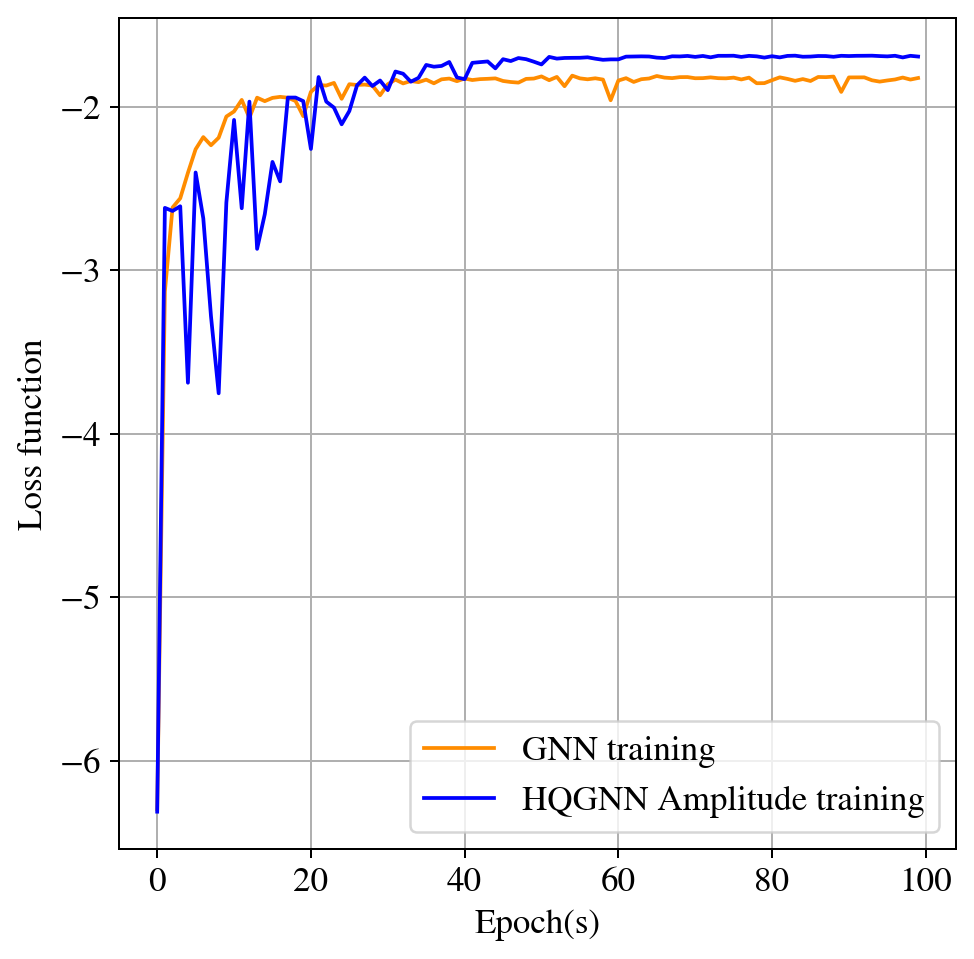

In [135]:
#record_gnn = np.load('gnn.npy')
# record_amplitude = np.load('amplitude.npy')
# record_angle = np.load('angle.npy')

record_gnn = np.array(record_gnn)
record_amplitude = np.array(record_amplitude)
# record_angle = np.array(record_angle)
# record_DL = np.array(record_edge)
skip = 1;start = 0
gnn_train =  [10*np.log10(-record_gnn[i, 0])  for i in range(start,100,skip)]
amplitude_train = [10*np.log10(-record_amplitude[i, 0])  for i in range(start,100,skip)]
#angle_train = record_angle[0::skip, 0]
# DL_train = record_DL[start::skip, 0]

gnn_test = [10*np.log10(-record_gnn[i, 1])  for i in range(start,100,skip)]
amplitude_test = [10*np.log10(-record_amplitude[i, 1])  for i in range(start,100,skip)]
#angle_test = record_angle[0::skip, 1]
# DL_test = record_DL[start::skip, 1]

from scipy.signal import savgol_filter

# gnn_train_smooth = savgol_filter(gnn_train, window_length=7, polyorder=3)
# amplitude_train_smooth = savgol_filter(amplitude_train, window_length=7, polyorder=3)
# DL_train_smooth = savgol_filter(DL_train, window_length=7, polyorder=3)

# gnn_test_smooth = savgol_filter(gnn_test, window_length=7, polyorder=3)
# amplitude_test_smooth = savgol_filter(amplitude_test, window_length=7, polyorder=3)
# DL_test_smooth = savgol_filter(DL_test, window_length=7, polyorder=3)

plt.rc("text", usetex=False)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(6, 6), dpi=180)

x_values = np.arange(start, 100, skip)

plt.plot(x_values, gnn_train, '-',color = 'darkorange', label='GNN training')
plt.plot(x_values, amplitude_train, 'b-', label='HQGNN Amplitude training')
# plt.plot(x_values, DL_train_smooth, 'k-', label='FCNN training')

# plt.plot(x_values, gnn_test, ':', color = 'darkorange', markersize=7, label='GNN validation', markevery=10)
# plt.plot(x_values, amplitude_test, 'b:', markersize=7, label='HQGNN Amplitude validation', markevery=10)
# plt.plot(x_values, DL_test_smooth, 'k:', markersize=7, label='FCNN validation', markevery=10)


plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

plt.xlabel('Epoch(s)')
plt.ylabel('Loss function')
plt.legend()

plt.grid(True)
plt.savefig('Convergence')
plt.show()

# Angle Embedding

In [136]:
import pennylane as qml
from pennylane import numpy as np

n_qubits = 5
dev = qml.device('default.qubit', wires=n_qubits)


In [207]:
n_layers_circuit_X2 = 4
def circuit_X2_entangling(weights, n_qubits):
    qml.CRX(weights[-1], wires=[n_qubits-1, 0])
    for i in range(n_qubits-1):
        qml.CRX(weights[i], wires=[i, (i+1)])

@qml.qnode(dev, interface='torch')
def circuit_X2(inputs, layer_weights):
    qml.AngleEmbedding(features=inputs, wires=range(n_qubits))
    for l in range(n_layers_circuit_X2):
        circuit_X2_entangling(layer_weights[l], n_qubits)
    return qml.probs(wires=range(n_qubits))
weight_shapes_circuit_X2 = { "layer_weights": (n_layers_circuit_X2, n_qubits)}

In [208]:
n_layers_circuit_Z2 = 4
def circuit_Z2_entangling(weights, n_qubits):
    qml.CRZ(weights[-1], wires=[n_qubits - 1, 0])
    for i in range(n_qubits - 1):
        qml.CRZ(weights[i], wires=[i, i + 1])

@qml.qnode(dev, interface='torch')
def circuit_Z2(inputs, layer_weights):
    qml.AngleEmbedding(features=inputs, wires=range(n_qubits))
    for l in range(n_layers_circuit_Z2):
        circuit_Z2_entangling(layer_weights[l], n_qubits)
    return qml.probs(wires=range(n_qubits))
weight_shapes_circuit_Z2 = { "layer_weights": (n_layers_circuit_Z2, n_qubits)}

In [209]:
def MLP(channels, batch_norm=True):
    return Seq(*[
        Seq(Lin(channels[i - 1], channels[i]), ReLU(), BN(channels[i]))
        for i in range(1, len(channels))
    ])
class Q_layer_angle(MessagePassing):
    def __init__(self,src_dim, dst_dim, edge_dim, out_dim, **kwargs):
        super(Q_layer_angle, self).__init__(aggr='mean')  
        self.lin_res = qml.qnn.TorchLayer(circuit_X2, weight_shapes_circuit_X2)
        self.lin_qml = qml.qnn.TorchLayer(circuit_Z2, weight_shapes_circuit_Z2)
        self.in_linear = nn.Linear(src_dim + dst_dim + edge_dim, out_dim)
        self.linear = nn.Linear(dst_dim, n_qubits)
        self.bn = BN(32)

    def forward(self, x, edge_index, edge_attr):
        feat_src, feat_dst = x
        out = self.propagate(edge_index=edge_index, x=(feat_src, feat_dst), edge_attr=edge_attr)
        out = out + self.lin_res(self.linear(feat_dst))
        return self.bn(out)

    def message(self, x_j, x_i, edge_attr):
        out = torch.cat([x_j, x_i, edge_attr], dim=1)
        out = self.in_linear(out)
        out = self.lin_qml(out)
        return out

    def update(self, aggr_out):
        return aggr_out

In [210]:
class RGCN_Hybrid_mid_angle(nn.Module):
    def __init__(self):
        super(RGCN_Hybrid_mid_angle, self).__init__()
        out_dim = n_qubits
        edge_dim = 2

        self.conv1 = HeteroConv({
            ('UE', 'com-by', 'AP'): Q_layer_angle(1, 1, edge_dim, out_dim),
            ('AP', 'com', 'UE'): Q_layer_angle(1, 1, edge_dim,out_dim)
        }, aggr='mean')

        self.conv2 = HeteroConv({
            ('UE', 'com-by', 'AP'): Q_layer_angle(32, 32, edge_dim, out_dim),
            ('AP', 'com', 'UE'): Q_layer_angle(32, 32, edge_dim, out_dim)
        }, aggr='mean')

        self.conv3 = HeteroConv({
             ('UE', 'com-by', 'AP'): Q_layer_angle(32, 32, edge_dim, out_dim),
             ('AP', 'com', 'UE'): Q_layer_angle(32, 32, edge_dim, out_dim)
         }, aggr='mean')

        self.mlp = MLP([32, 16])
        self.mlp = nn.Sequential(*[self.mlp, Seq(Lin(16, 1), Sigmoid())])
    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        out = self.conv1(x_dict, edge_index_dict, edge_attr_dict)
        out = self.conv2(out, edge_index_dict, edge_attr_dict)
        out = self.conv3(out, edge_index_dict, edge_attr_dict)
        out = self.mlp(out['UE'])
        return out

In [211]:
model_qml_mid_angle = RGCN_Hybrid_mid_angle().to()

optimizer_qml_mid_angle = torch.optim.Adam(model_qml_mid_angle.parameters(), lr=5e-4)
scheduler_qml_mid_angle = torch.optim.lr_scheduler.StepLR(optimizer_qml_mid_angle, step_size=10, gamma=0.65)

In [212]:
trainable_params = sum(p.numel() for p in model_qml_mid_angle.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 3271


In [213]:
record_angle = []

for epoch in range(0, 100):

    with torch.no_grad():
        test_rate = test_model(test_loader, model_qml_mid_angle)
        train_rate = test_model(train_loader, model_qml_mid_angle)
        record_angle.append([train_rate, test_rate])
    if epoch % 1 == 0:
        print(f'Epoch {epoch:02d}, Train Rate: {train_rate:.4f}, Test Rate: {test_rate:.4f}')
    train_model(epoch, model_qml_mid_angle, optimizer_qml_mid_angle, train_loader)
    scheduler_qml_mid_angle.step()

Epoch 00, Train Rate: -0.2346, Test Rate: -0.2583
Epoch 01, Train Rate: -0.5252, Test Rate: -0.5348
Epoch 02, Train Rate: -0.5928, Test Rate: -0.5936
Epoch 03, Train Rate: -0.6029, Test Rate: -0.6016
Epoch 04, Train Rate: -0.6126, Test Rate: -0.6102
Epoch 05, Train Rate: -0.6102, Test Rate: -0.6089
Epoch 06, Train Rate: -0.6136, Test Rate: -0.6116
Epoch 07, Train Rate: -0.5447, Test Rate: -0.5489
Epoch 08, Train Rate: -0.6132, Test Rate: -0.6159
Epoch 09, Train Rate: -0.6333, Test Rate: -0.6336
Epoch 10, Train Rate: -0.6314, Test Rate: -0.6324
Epoch 11, Train Rate: -0.6302, Test Rate: -0.6333
Epoch 12, Train Rate: -0.5935, Test Rate: -0.5957
Epoch 13, Train Rate: -0.6163, Test Rate: -0.6191
Epoch 14, Train Rate: -0.6453, Test Rate: -0.6452
Epoch 15, Train Rate: -0.6412, Test Rate: -0.6401
Epoch 16, Train Rate: -0.6446, Test Rate: -0.6462
Epoch 17, Train Rate: -0.6435, Test Rate: -0.6446
Epoch 18, Train Rate: -0.6474, Test Rate: -0.6491
Epoch 19, Train Rate: -0.6368, Test Rate: -0.6375


In [214]:
# np.save('gnn.npy', record_gnn)
# np.save('amplitude.npy', record_amplitude)
np.save('angle.npy', record_angle)

# CDF

In [26]:
num = 1000

In [33]:
test_5 = scipy.io.loadmat('../test_cdf/cf_50_20.mat')
beta_5 = test_5['betas'][:num]
direct_5 = test_5['directs'][:num]
cross_5 = test_5['corsses'][:num].transpose(0,2,1)

In [34]:
norm_train_5, norm_test_5 = normalize_data(beta_5**(1/2), beta_5**(1/2) )

In [35]:
test_5 = PCDataset(norm_test_5, direct_5, cross_5, (20, 50))
test_5_loader = DataLoader(test_5, test_layouts, shuffle=False, collate_fn=collate)

In [36]:
test_4 = scipy.io.loadmat('../test_cdf/cf_20_4.mat')
beta_4 = test_4['betas'][:num]
direct_4 = test_4['directs'][:num]
cross_4 = test_4['corsses'][:num].transpose(0,2,1)

In [37]:
norm_train_4, norm_test_4 = normalize_data(beta_4**(1/2), beta_4**(1/2) )

In [38]:
test_4 = PCDataset(norm_train_4, direct_4, cross_4, (4, 20))
test_4_loader = DataLoader(test_4, test_layouts, shuffle=False, collate_fn=collate)

In [39]:
all_one_rates_5 = []
random_rates_5 = []
gnn_rates_amplitude_5 = []
for (data, d_test, c_test) in test_5_loader:
    K = d_test.shape[-1]
    n = len(data['UE'].x)
    bs = len(data['UE'].x) // K
    user_feats = data['AP'].x
    item_feats = data['UE'].x
    node_features = {'AP': user_feats, 'UE': item_feats}
    output1 = model_qml_amplitude(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs,-1)
    gnn_rates_amplitude_5.append(rate_loss(output1, d_test, c_test, True).flatten().detach().numpy())
    full = torch.ones_like(output1)
    all_one_rates_5.append(rate_loss(full, d_test, c_test, True).flatten().detach().numpy())
    rand = torch.rand_like(output1)
    random_rates_5.append(rate_loss(rand, d_test, c_test, True).flatten().detach().numpy())

: 

In [153]:
min_rate, max_rate = 0, 3.0
y_axis = np.linspace(0, 1.0, num + 2, endpoint=False)
gnn_rates_amplitude_5 = np.concatenate(gnn_rates_amplitude_5)
random_rates_5 = np.concatenate(random_rates_5)
all_one_rates_5 = np.concatenate(all_one_rates_5)

all_one_rates_5 = np.sort(all_one_rates_5) 
gnn_rates_amplitude_5 = np.sort(gnn_rates_amplitude_5)
random_rates_5 = np.sort(random_rates_5)
gnn_rates_amplitude_5 = np.insert(gnn_rates_amplitude_5, 0, min_rate); gnn_rates_amplitude_5 = np.insert(gnn_rates_amplitude_5,num+1,max_rate)
#gnn_rates_angle = np.insert(gnn_rates_angle, 0, min_rate); gnn_rates_angle = np.insert(gnn_rates_angle,201,max_rate)
random_rates_5 = np.insert(random_rates_5, 0, min_rate); random_rates_5 = np.insert(random_rates_5, num+1, max_rate)
#opt_rates = np.insert(opt_rates, 0, min_rate); opt_rates = np.insert(opt_rates, 201, max_rate)
all_one_rates_5 = np.insert(all_one_rates_5, 0, min_rate); all_one_rates_5 = np.insert(all_one_rates_5,num+1,max_rate)

In [154]:
all_one_4 = []
random_4 = []
gnn_amplitude_4 = []
for (data, d_test, c_test) in test_4_loader:
    K = d_test.shape[-1]
    n = len(data['UE'].x)
    bs = len(data['UE'].x) // K
    user_feats = data['AP'].x
    item_feats = data['UE'].x
    node_features = {'AP': user_feats, 'UE': item_feats}
    output1 = model_qml_amplitude(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs,-1)
    #output2 = model_qml_mid_angle(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs,-1)
    gnn_amplitude_4.append(rate_loss(output1, d_test, c_test, True).flatten().detach().numpy())
    #gnn_angle_5 = rate_loss(output2, d_test, c_test, True).flatten().detach().numpy()
    full = torch.ones_like(output1)
    all_one_4.append(rate_loss(full, d_test, c_test, True).flatten().detach().numpy())
    rand = torch.rand_like(output1)
    random_4.append(rate_loss(rand, d_test, c_test, True).flatten().detach().numpy())

In [155]:
min_rate, max_rate = 0, 2
y_axis = np.linspace(0, 1.0, num + 2, endpoint=False)
gnn_amplitude_4 = np.concatenate(gnn_amplitude_4)
random_4 = np.concatenate(random_4)
all_one_4 = np.concatenate(all_one_4)
all_one_4 = np.sort(all_one_4) 
gnn_amplitude_4  = np.sort(gnn_amplitude_4 )
random_4 = np.sort(random_4)
gnn_amplitude_4 = np.insert(gnn_amplitude_4, 0, min_rate); gnn_amplitude_4 = np.insert(gnn_amplitude_4,num+1,max_rate)
random_4= np.insert(random_4, 0, min_rate); random_4 = np.insert(random_4, num + 1, max_rate)
all_one_4 = np.insert(all_one_4, 0, min_rate); all_one_4 = np.insert(all_one_4,num + 1,max_rate)

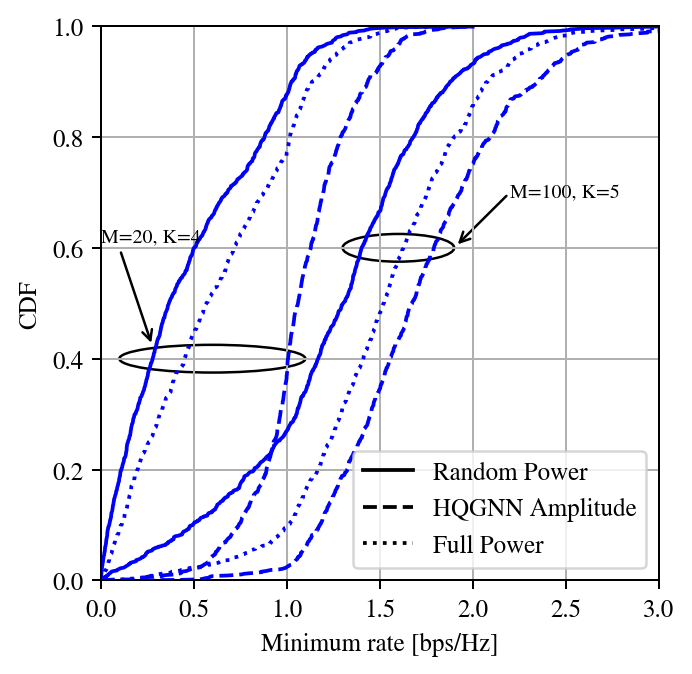

In [156]:
from matplotlib.lines import Line2D
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, FancyArrowPatch

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(figsize=(4, 4), dpi=180)
# First network setting (e.g., M=20, K=4)

ax.plot(random_4, y_axis, label='Random Power', color='blue')
ax.plot(gnn_amplitude_4, y_axis, label='HQGNN Amplitude', color='blue', linestyle='--')
ax.plot(all_one_4, y_axis, label='Maximum Power', color='blue', linestyle=':')

# Second network setting (e.g., M=100, K=5)
ax.plot(random_rates_5, y_axis, label='Random Power', color='blue')
ax.plot(gnn_rates_amplitude_5, y_axis, label='HQGNN Amplitude', color='blue', linestyle='--')
ax.plot(all_one_rates_5, y_axis, label='Maximum Power', color='blue', linestyle=':')

# Custom legend
custom_lines = [
    #Line2D([0], [0], color='white', label='M=30, K=6'),
    Line2D([0], [0], color='black', label='Random Power'),
    Line2D([0], [0], color='black', linestyle='--', label='HQGNN Amplitude'),
    Line2D([0], [0], color='black', linestyle=':', label='Full Power'),
    #Line2D([0], [0], color='white', label='M=100, K=5'),
    #Line2D([0], [0], color='red', label='Random Power'),
    #Line2D([0], [0], color='red', linestyle='--', label='HQGNN Amplitude'),
    #Line2D([0], [0], color='red', linestyle=':', label='Full Power'),
    #Line2D([0],[0],label='Optimal')
]

# Add custom legend to the plot
ax.legend(handles=custom_lines, loc='lower right', frameon=True)


# Axis labels and grid
ax.set_xlabel('Minimum rate [bps/Hz]')
ax.set_ylabel('CDF')
ax.grid()
ax.set_xlim(0.0, 3.0)
ax.set_ylim(0.0, 1.0)
# Thêm hình elip cho vùng CDF của Random Power (blue) và HQGNN Amplitude (blue)
ellipse1 = Ellipse(xy=(0.6, 0.4), width=1, height=0.05, edgecolor='black', facecolor='none', linewidth=1)
ax.add_patch(ellipse1)

# Thêm hình elip cho vùng CDF của Random Power (red) và HQGNN Amplitude (red)
ellipse2 = Ellipse(xy=(1.6, 0.6), width=0.6, height=0.05, edgecolor='black', facecolor='none', linewidth=1)
ax.add_patch(ellipse2)


ax.text(-0.00, 0.62, "M=20, K=4", fontsize=8, verticalalignment='center', horizontalalignment='left', color='black')
arrow1 = FancyArrowPatch((0.1, 0.6), (0.28, 0.42), arrowstyle='->', mutation_scale=10, color='black')
ax.add_patch(arrow1)

ax.text(2.2, 0.7, "M=100, K=5", fontsize=8, verticalalignment='center', horizontalalignment='left', color='black')
arrow2 = FancyArrowPatch((2.2, 0.7), (1.9, 0.6), arrowstyle='->', mutation_scale=10, color='black')
ax.add_patch(arrow2)
plt.savefig("CDF")
plt.show()


DL Method https://github.com/BJTU-MIMO/CF-DL-Power-Control

In [157]:
class DLDataset(Dataset):
    def __init__(self, norm_losses, direct, cross, KM):
        self.norm_losses = torch.tensor(norm_losses, dtype=torch.float)
        self.direct = torch.tensor(direct, dtype=torch.float)
        self.cross = torch.tensor(cross, dtype=torch.float)
        self.KM = KM
        self.x = torch.sum((self.norm_losses), axis = 1)


    def __len__(self):
        return len(self.direct)

    def __getitem__(self, index):
        return self.x[index], self.direct[index], self.cross[index]

In [158]:
train_DL = DLDataset(norm_train_losses, direct_train, cross_train, (train_K, train_M))
test_DL = DLDataset(norm_test_losses, direct_test, cross_test, (test_K, test_M))
batch_size = 64
train_loader_DL = DataLoader(train_DL, batch_size, shuffle=True, collate_fn=collate)
test_loader_DL = DataLoader(test_DL, test_layouts, shuffle=False, collate_fn=collate)

In [159]:
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=6, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=128)
        self.output = nn.Linear(in_features=128, out_features=6)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))     
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.output(x))
        return x

In [160]:
model_ANN = ANN()
optimizer_ANN = torch.optim.Adam(model_ANN.parameters(), lr = 5e-3)
scheduler_ANN = torch.optim.lr_scheduler.StepLR(optimizer_ANN, step_size=10, gamma = 1/3)
trainable_params = sum(p.numel() for p in model_ANN.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 67590


In [161]:
def train_model_DL(model, optimizer, train_loader):
    """ Train for one epoch with flat data on CPU. """
    model.train()
    loss_all = 0

    for batch_idx, (data, d_train, c_train) in enumerate(train_loader):
        optimizer.zero_grad()

        # Truyền qua mô hình ANN
        output = model(data)

        # Tính loss và thực hiện backpropagation
        loss = rate_loss(output, d_train, c_train)
        loss.backward()

        loss_all += loss.item() * len(data)
        optimizer.step()

    return loss_all / len(train_loader.dataset)
def test_model_DL(loader, model):
    """ Evaluate the model on the test dataset using CPU. """
    model.eval()
    loss_all = 0

    with torch.no_grad():
        for batch_idx, (data, d_test, c_test) in enumerate(loader):
            # Truyền qua mô hình ANN
            output = model(data)

            # Tính loss
            loss = rate_loss(output, d_test, c_test)
            loss_all += loss.item() * len(data)

    return loss_all / len(loader.dataset)

In [162]:
record_edge = []

for epoch in range(0, 100):

    with torch.no_grad():
        test_rate = test_model_DL(test_loader_DL, model_ANN)
        train_rate = test_model_DL(train_loader_DL, model_ANN)
        record_edge.append([train_rate, test_rate])
    if epoch % 1 == 0:
        print(f'Epoch {epoch:02d}, Train Rate: {train_rate:.4f}, Test Rate: {test_rate:.4f}')
    train_model_DL(model_ANN, optimizer_ANN, train_loader_DL)
    scheduler_ANN.step()

Epoch 00, Train Rate: -0.2371, Test Rate: -0.2631
Epoch 01, Train Rate: -0.4684, Test Rate: -0.4754
Epoch 02, Train Rate: -0.5046, Test Rate: -0.5044
Epoch 03, Train Rate: -0.5475, Test Rate: -0.5497
Epoch 04, Train Rate: -0.5459, Test Rate: -0.5464
Epoch 05, Train Rate: -0.5472, Test Rate: -0.5469
Epoch 06, Train Rate: -0.5482, Test Rate: -0.5522
Epoch 07, Train Rate: -0.5504, Test Rate: -0.5462
Epoch 08, Train Rate: -0.5573, Test Rate: -0.5548
Epoch 09, Train Rate: -0.5572, Test Rate: -0.5540
Epoch 10, Train Rate: -0.5632, Test Rate: -0.5637
Epoch 11, Train Rate: -0.5915, Test Rate: -0.5848
Epoch 12, Train Rate: -0.5927, Test Rate: -0.5842
Epoch 13, Train Rate: -0.5955, Test Rate: -0.5840
Epoch 14, Train Rate: -0.5997, Test Rate: -0.5859
Epoch 15, Train Rate: -0.5969, Test Rate: -0.5844
Epoch 16, Train Rate: -0.5981, Test Rate: -0.5870
Epoch 17, Train Rate: -0.6019, Test Rate: -0.5873
Epoch 18, Train Rate: -0.6020, Test Rate: -0.5869
Epoch 19, Train Rate: -0.6023, Test Rate: -0.5871


In [220]:
np.save('FCNN.npy', record_edge)

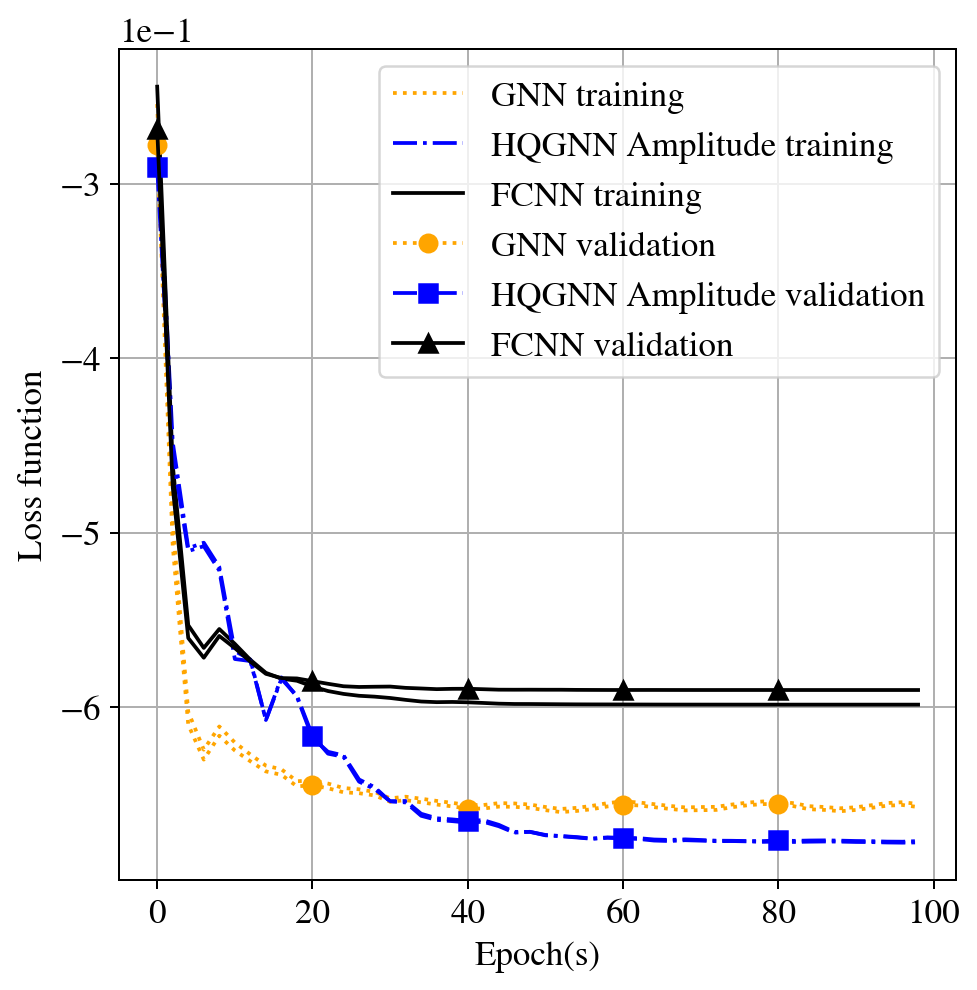

In [ ]:
record_gnn = np.load('gnn.npy')
record_amplitude = np.load('amplitude.npy')
record_angle = np.load('angle.npy')
record_edge = np.load('FCNN.npy')

record_gnn = np.array(record_gnn)
record_amplitude = np.array(record_amplitude)
record_angle = np.array(record_angle)
record_DL = np.array(record_edge)
skip = 2
gnn_train = record_gnn[0::skip, 0]
amplitude_train = record_amplitude[0::skip, 0]
#angle_train = record_angle[0::skip, 0]
DL_train = record_DL[0::skip, 0]

gnn_test = record_gnn[0::skip, 1]
amplitude_test = record_amplitude[0::skip, 1]
#angle_test = record_angle[0::skip, 1]
DL_test = record_DL[0::skip, 1]

from scipy.signal import savgol_filter

gnn_train_smooth = savgol_filter(gnn_train, window_length=7, polyorder=3)
amplitude_train_smooth = savgol_filter(amplitude_train, window_length=7, polyorder=3)
DL_train_smooth = savgol_filter(DL_train, window_length=7, polyorder=3)

gnn_test_smooth = savgol_filter(gnn_test, window_length=7, polyorder=3)
amplitude_test_smooth = savgol_filter(amplitude_test, window_length=7, polyorder=3)
DL_test_smooth = savgol_filter(DL_test, window_length=7, polyorder=3)

plt.rc("text", usetex=False)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(6, 6), dpi=180)

x_values = np.arange(0, 100, 2)

plt.plot(x_values, gnn_train_smooth, ':',color = 'orange', label='GNN training')
plt.plot(x_values, amplitude_train_smooth, 'b-.', label='HQGNN Amplitude training')
plt.plot(x_values, DL_train_smooth, 'k-', label='FCNN training')

plt.plot(x_values, gnn_test_smooth, ':', color = 'orange',marker='o', markersize=7, label='GNN validation', markevery=10)
plt.plot(x_values, amplitude_test_smooth, 'b-.', marker='s', markersize=7, label='HQGNN Amplitude validation', markevery=10)
plt.plot(x_values, DL_test_smooth, 'k-', marker='^', markersize=7, label='FCNN validation', markevery=10)


plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

plt.xlabel('Epoch(s)')
plt.ylabel('Loss function')
plt.legend()

plt.grid(True)
plt.show()

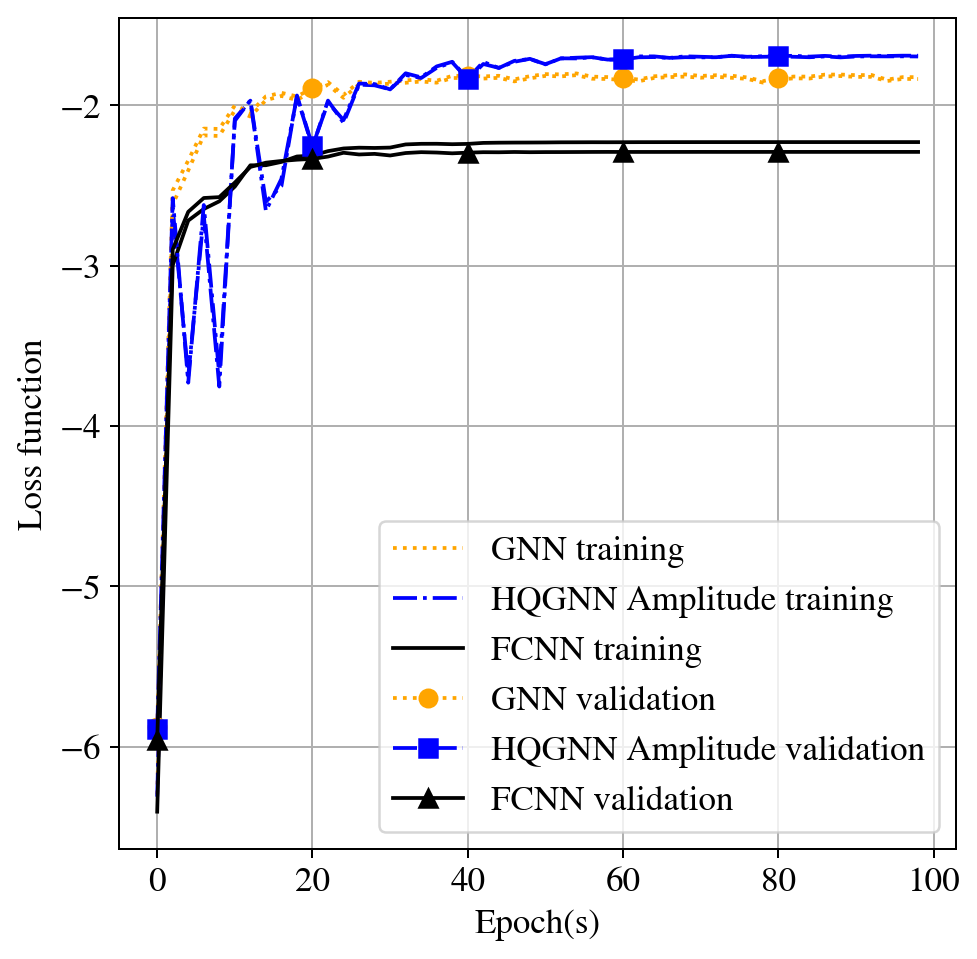

In [217]:
# record_gnn = np.load('gnn.npy')
# record_amplitude = np.load('amplitude.npy')
# record_angle = np.load('angle.npy')

record_gnn = np.array(record_gnn)
record_amplitude = np.array(record_amplitude)
record_angle = np.array(record_angle)
record_DL = np.array(record_edge)
skip = 2
gnn_train =  [10*np.log10(-record_gnn[i,0]) for i in range(0,100, skip)]
amplitude_train = [10*np.log10(-record_amplitude[i,0]) for i in range(0,100, skip)]
#angle_train = record_angle[0::skip, 0]
DL_train = [10*np.log10(-record_DL[i,0]) for i in range(0,100, skip)]

gnn_test = [10*np.log10(-record_gnn[i,1]) for i in range(0,100, skip)]
amplitude_test = [10*np.log10(-record_amplitude[i,1]) for i in range(0,100, skip)]

#angle_test = record_angle[0::skip, 1]
DL_test = [10*np.log10(-record_DL[i,1]) for i in range(0,100, skip)]


from scipy.signal import savgol_filter

# gnn_train_smooth = savgol_filter(gnn_train, window_length=7, polyorder=3)
# amplitude_train_smooth = savgol_filter(amplitude_train, window_length=7, polyorder=3)
# DL_train_smooth = savgol_filter(DL_train, window_length=7, polyorder=3)

# gnn_test_smooth = savgol_filter(gnn_test, window_length=7, polyorder=3)
# amplitude_test_smooth = savgol_filter(amplitude_test, window_length=7, polyorder=3)
# DL_test_smooth = savgol_filter(DL_test, window_length=7, polyorder=3)

plt.rc("text", usetex=False)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(6, 6), dpi=180)

x_values = np.arange(0, 100, 2)

plt.plot(x_values, gnn_train, ':',color = 'orange', label='GNN training')
plt.plot(x_values, amplitude_train, 'b-.', label='HQGNN Amplitude training')
plt.plot(x_values, DL_train, 'k-', label='FCNN training')

plt.plot(x_values, gnn_test, ':', color = 'orange',marker='o', markersize=7, label='GNN validation', markevery=10)
plt.plot(x_values, amplitude_test, 'b-.', marker='s', markersize=7, label='HQGNN Amplitude validation', markevery=10)
plt.plot(x_values, DL_test, 'k-', marker='^', markersize=7, label='FCNN validation', markevery=10)


plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

plt.xlabel('Epoch(s)')
plt.ylabel('Loss function')
plt.legend()

plt.grid(True)
plt.show()

In [215]:
# torch.save(model.state_dict(), 'model_parameters.pth')
# torch.save(model_qml_amplitude.state_dict(), 'model_amplitude_parameters.pth')
torch.save(model_qml_mid_angle.state_dict(), 'model_angle_parameters.pth')

In [25]:
model.load_state_dict(torch.load('model_parameters.pth'))
model_qml_amplitude.load_state_dict(torch.load('model_amplitude_parameters.pth'))
#model_qml_mid_angle.load_state_dict(torch.load('model_angle_parameters.pth'))

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18652\195641434.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_parameters.pth'))
C:\

<All keys matched successfully>

In [218]:
import pandas as pd
models = {
    "GNN": model,
    "HQGNN Amplitude": model_qml_amplitude,
    "HQGNN Angle": model_qml_mid_angle,
}

params_count = {name: sum(p.numel() for p in model.parameters()) for name, model in models.items()}

avg_gnn_test_rates_angle = -test_model(test_loader, model_qml_mid_angle)
avg_gnn_test_rates_amplitude = -test_model(test_loader, model_qml_amplitude)
avg_gnn_test_rates = -test_model(test_loader, model)
test_data = scipy.io.loadmat('cf_test_6_30_2.mat')
opt_rates = np.mean(test_data['R_cf_opt_min'])


performance_percentages = {
    "GNN": (avg_gnn_test_rates / opt_rates) * 100,
    "HQGNN Amplitude": (avg_gnn_test_rates_amplitude / opt_rates) * 100,
    "HQGNN Angle": (avg_gnn_test_rates_angle / opt_rates) * 100,
}
data = {
    "Model": ["GNN", "HQGNN Amplitude", "HQGNN Angle"],
    "Parameter Numbers": [params_count["GNN"], params_count["HQGNN Amplitude"], params_count["HQGNN Angle"]],
    "Performance (%)": [performance_percentages["GNN"], performance_percentages["HQGNN Amplitude"], performance_percentages["HQGNN Angle"]]
}
params_df = pd.DataFrame(data)
print(params_df)


             Model  Parameter Numbers  Performance (%)
0              GNN              14593        90.473471
1  HQGNN Amplitude               9977        93.025203
2      HQGNN Angle               3271        91.282381


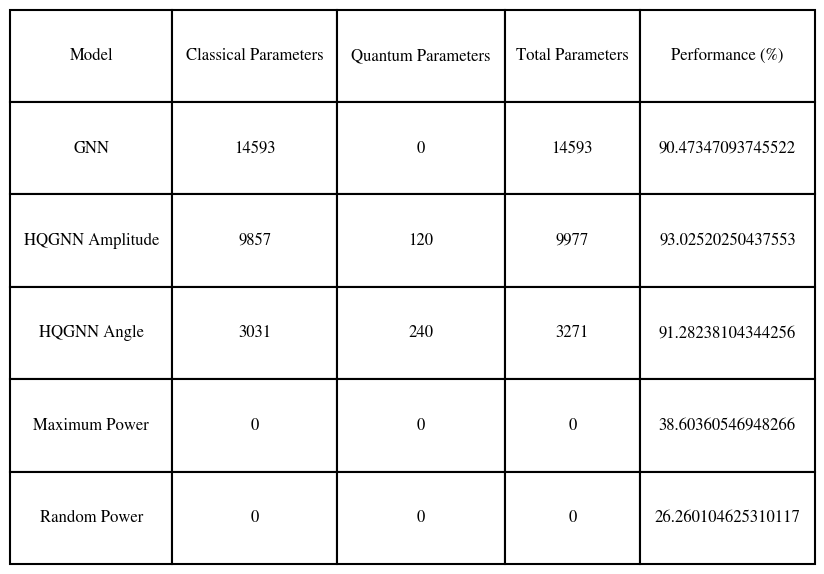

In [219]:
import pandas as pd
import matplotlib.pyplot as plt

def count_parameters(model):
    quantum_params = 0
    classical_params = 0
    for name, param in model.named_parameters():
        if 'lin_qml' in name or 'lin_res' in name:  # Phân loại các tham số thuộc về Quantum
            quantum_params += param.numel()
        else:  # Các tham số khác thuộc về Classical
            classical_params += param.numel()
    return quantum_params, classical_params

models = {
    "GNN": model,
    "HQGNN Amplitude": model_qml_amplitude,
    "HQGNN Angle": model_qml_mid_angle,
}

params_count = {
    name: count_parameters(model)
    for name, model in models.items()
}

avg_gnn_test_rates_angle = -test_model(test_loader, model_qml_mid_angle)
avg_gnn_test_rates_amplitude = -test_model(test_loader, model_qml_amplitude)
avg_gnn_test_rates = -test_model(test_loader, model)

for (data, d_test, c_test) in test_loader:
    K = d_test.shape[-1]
    n = len(data['UE'].x)
    bs = len(data['UE'].x) // K
    user_feats = data['AP'].x
    item_feats = data['UE'].x
    node_features = {'AP': user_feats, 'UE': item_feats}
    output = model(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs,-1)
    full = torch.ones_like(output)
    all_one_rates = -rate_loss(full, d_test, c_test).detach().numpy()
    rand = torch.rand_like(output)
    random_rates = -rate_loss(rand, d_test, c_test).detach().numpy()

test_data = scipy.io.loadmat('cf_test_6_30_2.mat')
opt_rates = np.sum(test_data['R_cf_opt_min']) / len(test_loader.dataset)

# Tính hiệu suất
performance_percentages = {
    "GNN": (avg_gnn_test_rates / opt_rates) * 100,
    "HQGNN Amplitude": (avg_gnn_test_rates_amplitude / opt_rates) * 100,
    "HQGNN Angle": (avg_gnn_test_rates_angle / opt_rates) * 100,
    "Maximum Power": (all_one_rates/opt_rates) * 100,
    "Random Power": (random_rates/opt_rates) * 100
}

# Tạo DataFrame chứa kết quả
data = {
    "Model": ["GNN", "HQGNN Amplitude", "HQGNN Angle","Maximum Power", "Random Power"],
    "Classical Parameters": [params_count["GNN"][1], params_count["HQGNN Amplitude"][1], params_count["HQGNN Angle"][1],0,0],
    "Quantum Parameters": [params_count["GNN"][0], params_count["HQGNN Amplitude"][0], params_count["HQGNN Angle"][0],0,0],
    "Total Parameters": [params_count["GNN"][0] + params_count["GNN"][1], params_count["HQGNN Amplitude"][0] + params_count["HQGNN Amplitude"][1],params_count["HQGNN Angle"][0] + params_count["HQGNN Angle"][1],0,0],
    "Performance (%)": [performance_percentages["GNN"], performance_percentages["HQGNN Amplitude"], performance_percentages["HQGNN Angle"], performance_percentages["Maximum Power"], performance_percentages["Random Power"]],
}


params_df = pd.DataFrame(data)

# Vẽ bảng
fig, ax = plt.subplots(figsize=(8, 4))  # Kích thước hình ảnh
ax.axis('tight')  # Loại bỏ trục
ax.axis('off')  # Loại bỏ viền trục
table = ax.table(cellText=params_df.values, colLabels=params_df.columns, loc='center', cellLoc='center')

# Tùy chỉnh bảng
table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(params_df.columns))))

# Tăng khoảng cách giữa các hàng và cột
for (row, col), cell in table.get_celld().items():
    cell.set_linewidth(1.5) 
    cell.set_height(0.3)   
    cell.set_width(0.25)    

plt.savefig("model_parameters_and_performance_table_full.png", dpi=300, bbox_inches='tight')
plt.show()


In [197]:
torch.save(model.state_dict(), 'model_parameters.pth')
torch.save(model_qml_amplitude.state_dict(), 'model_amplitude_parameters.pth')
torch.save(model_qml_mid_angle.state_dict(), 'model_angle_parameters.pth')

In [169]:
# model.load_state_dict(torch.load('model_parameters.pth'))
# model_qml_amplitude.load_state_dict(torch.load('model_amplitude_parameters.pth'))
# model_qml_mid_angle.load_state_dict(torch.load('model_angle_parameters.pth'))

# Same Parameter

In [170]:
def MLP(channels, batch_norm=True):
    return Seq(*[
        Seq(Lin(channels[i - 1], channels[i]), ReLU(), BN(channels[i]))
        for i in range(1, len(channels))
    ])
class EdgeConv_same(MessagePassing):
    def __init__(self, input_dim, node_dim, dim_out, **kwargs):
        super(EdgeConv_same, self).__init__(aggr='mean')  # mean aggregation
        self.lin = MLP([input_dim, dim_out])
        self.res_lin = Lin(node_dim, dim_out)
        self.bn = BN(dim_out)

    def forward(self, x, edge_index, edge_attr):

        feat_src, feat_dst = x


        out = self.propagate(edge_index=edge_index, x=(feat_src, feat_dst), edge_attr=edge_attr)


        return self.bn(out + self.res_lin(feat_dst))

    def message(self, x_j, x_i, edge_attr):
        # Tạo ra thông điệp từ các nút nguồn, nút đích và đặc tính cạnh
        out = torch.cat([x_j, x_i, edge_attr], dim=1)
        return self.lin(out)

    def update(self, aggr_out):
        # Cập nhật giá trị nút đích sau khi tập hợp
        return aggr_out



In [171]:
class RGCN_same(nn.Module):
    def __init__(self):
        super(RGCN_same, self).__init__()
        self.conv1 = HeteroConv({
            ('UE', 'com-by', 'AP'): EdgeConv_same(4, 1, 13),
            ('AP', 'com', 'UE'): EdgeConv_same(4, 1, 13)
        }, aggr='mean')

        self.conv2 = HeteroConv({
            ('UE', 'com-by', 'AP'): EdgeConv_same(28, 13, 13),
            ('AP', 'com', 'UE'): EdgeConv_same(28, 13, 13)
        }, aggr='mean')

        self.conv3 = HeteroConv({
            ('UE', 'com-by', 'AP'): EdgeConv_same(28, 13, 13),
            ('AP', 'com', 'UE'): EdgeConv_same(28, 13, 13)
        }, aggr='mean')

        self.mlp = MLP([13, 16])
        self.mlp = nn.Sequential(*[self.mlp, Seq(Lin(16, 1), Sigmoid())])
    def forward(self,x_dict, edge_index_dict, edge_attr_dict):
        out = self.conv1(x_dict, edge_index_dict, edge_attr_dict)
        out = self.conv2(out, edge_index_dict, edge_attr_dict)
        out = self.conv3(out, edge_index_dict, edge_attr_dict)
        out = self.mlp(out['UE'])
        return out


In [172]:
model_gnn = RGCN_same()
optimizer = torch.optim.Adam(model_gnn.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [173]:
trainable_params = sum(p.numel() for p in model_gnn.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 3003


In [174]:
n_qubits_amplitude = 4
dev = qml.device('default.qubit', wires=n_qubits)


In [175]:
n_layers_circuit_X = 2
def circuit_X_entangling(weights, n_qubits_amplitude):
    qml.CRX(weights[-1], wires=[n_qubits_amplitude-1, 0])
    for i in range(n_qubits_amplitude-1):
        qml.CRX(weights[i], wires=[i, (i+1)])

@qml.qnode(dev, interface='torch')
def circuit_X(inputs, layer_weights):
    qml.AmplitudeEmbedding(features=inputs, wires=range(n_qubits_amplitude), normalize=True, pad_with=0.)
    for l in range(n_layers_circuit_X):
        circuit_X_entangling(layer_weights[l], n_qubits_amplitude)
    return qml.probs(wires=range(n_qubits_amplitude))
weight_shapes_circuit_X = { "layer_weights": (n_layers_circuit_X, n_qubits_amplitude)}

In [176]:
n_layers_circuit_Z = 2
def circuit_Z_entangling(weights, n_qubits_amplitude):
    qml.CRZ(weights[-1], wires=[n_qubits_amplitude - 1, 0])
    for i in range(n_qubits_amplitude - 1):
        qml.CRZ(weights[i], wires=[i, i + 1])

@qml.qnode(dev, interface='torch')
def circuit_Z(inputs, layer_weights):
    qml.AmplitudeEmbedding(features=inputs, wires=range(n_qubits_amplitude), normalize=True, pad_with=0.)
    for l in range(n_layers_circuit_Z):
        circuit_Z_entangling(layer_weights[l], n_qubits_amplitude)
    return qml.probs(wires=range(n_qubits_amplitude))
weight_shapes_circuit_Z = { "layer_weights": (n_layers_circuit_Z, n_qubits_amplitude)}

In [177]:
class Q_layer_same(MessagePassing):
    def __init__(self,src_dim, dst_dim, edge_dim, **kwargs):
        super(Q_layer_same, self).__init__(aggr='mean')  # mean aggregation
        self.lin_res = qml.qnn.TorchLayer(circuit_Z, weight_shapes_circuit_Z)
        self.lin_qml = qml.qnn.TorchLayer(circuit_X, weight_shapes_circuit_X)
        self.in_linear = nn.Linear(src_dim + dst_dim + edge_dim, 2 ** n_qubits_amplitude)
        self.bn = BN(2 ** n_qubits_amplitude)

    def forward(self, x, edge_index, edge_attr):
        feat_src, feat_dst = x
        out = self.propagate(edge_index=edge_index, x=(feat_src, feat_dst), edge_attr=edge_attr)
        out = out + self.lin_res(feat_dst)
        return self.bn(out)

    def message(self, x_j, x_i, edge_attr):
        out = torch.cat([x_j, x_i, edge_attr], dim=1)
        out = self.in_linear(out)
        out = self.lin_qml(out)
        return out

    def update(self, aggr_out):
        return aggr_out

In [178]:
class RGCN_Hybrid_amplitude_same(nn.Module):
    def __init__(self):
        super(RGCN_Hybrid_amplitude_same, self).__init__()
        out_dim = 2**n_qubits_amplitude
        edge_dim = 2

        self.conv1 = HeteroConv({
            ('UE', 'com-by', 'AP'): Q_layer_same(1, 1, edge_dim),
            ('AP', 'com', 'UE'): Q_layer_same(1, 1, edge_dim,)
        }, aggr='mean')

        self.conv2 = HeteroConv({
            ('UE', 'com-by', 'AP'): Q_layer_same(out_dim, out_dim, edge_dim),
            ('AP', 'com', 'UE'): Q_layer_same(out_dim, out_dim, edge_dim)
        }, aggr='mean')

        self.conv3 = HeteroConv({
             ('UE', 'com-by', 'AP'): Q_layer_same(out_dim, out_dim, edge_dim),
             ('AP', 'com', 'UE'): Q_layer_same(out_dim, out_dim, edge_dim)
         }, aggr='mean')

        self.mlp = MLP([16, 20])
        self.mlp = nn.Sequential(*[self.mlp, Seq(Lin(20, 1), Sigmoid())])
    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        out = self.conv1(x_dict, edge_index_dict, edge_attr_dict)
        out = self.conv2(out, edge_index_dict, edge_attr_dict)
        out = self.conv3(out, edge_index_dict, edge_attr_dict)
        out = self.mlp(out['UE'])
        return out

In [179]:
model_amplitude_same = RGCN_Hybrid_amplitude_same().to()

optimizer_amplitude_same = torch.optim.Adam(model_amplitude_same.parameters(), lr=5e-4)
scheduler_amplitude_same = torch.optim.lr_scheduler.StepLR(optimizer_amplitude_same, step_size=10, gamma=0.6)

In [180]:
trainable_params = sum(p.numel() for p in model_amplitude_same.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 3089


In [181]:
record_gnn_same = []

for epoch in range(0, 100):
    if epoch % 1 == 0:
        with torch.no_grad():
            test_rate = test_model(test_loader, model_gnn)
            train_rate = test_model(train_loader, model_gnn)
        print(f'Epoch {epoch:03d}, Train Rate: {train_rate:.4f}, Test Rate: {test_rate:.4f}')
        record_gnn_same.append([train_rate, test_rate])

    train_model(epoch, model_gnn, optimizer, train_loader )
    scheduler.step()


Epoch 000, Train Rate: -0.2347, Test Rate: -0.2585
Epoch 001, Train Rate: -0.3262, Test Rate: -0.3451
Epoch 002, Train Rate: -0.4159, Test Rate: -0.4323
Epoch 003, Train Rate: -0.4553, Test Rate: -0.4710
Epoch 004, Train Rate: -0.4866, Test Rate: -0.5002
Epoch 005, Train Rate: -0.4137, Test Rate: -0.4268
Epoch 006, Train Rate: -0.5301, Test Rate: -0.5413
Epoch 007, Train Rate: -0.5426, Test Rate: -0.5532
Epoch 008, Train Rate: -0.5597, Test Rate: -0.5686
Epoch 009, Train Rate: -0.5668, Test Rate: -0.5756
Epoch 010, Train Rate: -0.5732, Test Rate: -0.5815
Epoch 011, Train Rate: -0.5929, Test Rate: -0.6000
Epoch 012, Train Rate: -0.5979, Test Rate: -0.6047
Epoch 013, Train Rate: -0.5999, Test Rate: -0.6060
Epoch 014, Train Rate: -0.6037, Test Rate: -0.6097
Epoch 015, Train Rate: -0.6032, Test Rate: -0.6096
Epoch 016, Train Rate: -0.6038, Test Rate: -0.6090
Epoch 017, Train Rate: -0.5954, Test Rate: -0.6024
Epoch 018, Train Rate: -0.6225, Test Rate: -0.6260
Epoch 019, Train Rate: -0.6161,

In [182]:
record_amplitude_same = []

for epoch in range(0, 100):

    with torch.no_grad():
        test_rate = test_model(test_loader, model_amplitude_same)
        train_rate = test_model(train_loader, model_amplitude_same)
        record_amplitude_same.append([train_rate, test_rate])
    if epoch % 1 == 0:
        print(f'Epoch {epoch:02d}, Train Rate: {train_rate:.4f}, Test Rate: {test_rate:.4f}')
    train_model(epoch, model_amplitude_same, optimizer_amplitude_same, train_loader)
    scheduler_amplitude_same.step()

Epoch 00, Train Rate: -0.2388, Test Rate: -0.2625
Epoch 01, Train Rate: -0.4782, Test Rate: -0.4797
Epoch 02, Train Rate: -0.5143, Test Rate: -0.5226
Epoch 03, Train Rate: -0.4722, Test Rate: -0.4761
Epoch 04, Train Rate: -0.5617, Test Rate: -0.5644
Epoch 05, Train Rate: -0.5741, Test Rate: -0.5778
Epoch 06, Train Rate: -0.4979, Test Rate: -0.4993
Epoch 07, Train Rate: -0.5493, Test Rate: -0.5495
Epoch 08, Train Rate: -0.5856, Test Rate: -0.5873
Epoch 09, Train Rate: -0.5783, Test Rate: -0.5830
Epoch 10, Train Rate: -0.5216, Test Rate: -0.5199
Epoch 11, Train Rate: -0.5949, Test Rate: -0.6010
Epoch 12, Train Rate: -0.5904, Test Rate: -0.5930
Epoch 13, Train Rate: -0.5923, Test Rate: -0.5919
Epoch 14, Train Rate: -0.6396, Test Rate: -0.6439
Epoch 15, Train Rate: -0.6287, Test Rate: -0.6323
Epoch 16, Train Rate: -0.5745, Test Rate: -0.5766
Epoch 17, Train Rate: -0.5921, Test Rate: -0.5930
Epoch 18, Train Rate: -0.5886, Test Rate: -0.5855
Epoch 19, Train Rate: -0.5601, Test Rate: -0.5578


In [206]:
torch.save(model_gnn.state_dict(), 'model_gnn_same.pth')
torch.save(model_amplitude_same.state_dict(), 'model_amplitude_same.pth')

# HQGNN Angle 

In [184]:
import pennylane as qml
from pennylane import numpy as np

n_qubits = 5
dev = qml.device('default.qubit', wires=n_qubits)


In [185]:
n_layers_circuit_X2 = 1
def circuit_X2_entangling(weights, n_qubits):
    qml.CRX(weights[-1], wires=[n_qubits-1, 0])
    for i in range(n_qubits-1):
        qml.CRX(weights[i], wires=[i, (i+1)])

@qml.qnode(dev, interface='torch')
def circuit_X2(inputs, layer_weights):
    qml.AngleEmbedding(features=inputs, wires=range(n_qubits))
    for l in range(n_layers_circuit_X2):
        circuit_X2_entangling(layer_weights[l], n_qubits)
    return qml.probs(wires=range(n_qubits))
weight_shapes_circuit_X2 = { "layer_weights": (n_layers_circuit_X2, n_qubits)}

In [186]:
n_layers_circuit_Z2 = 1
def circuit_Z2_entangling(weights, n_qubits):
    qml.CRZ(weights[-1], wires=[n_qubits - 1, 0])
    for i in range(n_qubits - 1):
        qml.CRZ(weights[i], wires=[i, i + 1])

@qml.qnode(dev, interface='torch')
def circuit_Z2(inputs, layer_weights):
    qml.AngleEmbedding(features=inputs, wires=range(n_qubits))
    for l in range(n_layers_circuit_Z2):
        circuit_Z2_entangling(layer_weights[l], n_qubits)
    return qml.probs(wires=range(n_qubits))
weight_shapes_circuit_Z2 = { "layer_weights": (n_layers_circuit_Z2, n_qubits)}

In [187]:
def MLP(channels, batch_norm=True):
    return Seq(*[
        Seq(Lin(channels[i - 1], channels[i]), ReLU(), BN(channels[i]))
        for i in range(1, len(channels))
    ])
class Q_layer_angle(MessagePassing):
    def __init__(self,src_dim, dst_dim, edge_dim, out_dim, **kwargs):
        super(Q_layer_angle, self).__init__(aggr='mean')  
        self.lin_res = qml.qnn.TorchLayer(circuit_X2, weight_shapes_circuit_X2)
        self.lin_qml = qml.qnn.TorchLayer(circuit_Z2, weight_shapes_circuit_Z2)
        self.in_linear = nn.Linear(src_dim + dst_dim + edge_dim, out_dim)
        self.linear = nn.Linear(dst_dim, n_qubits)
        self.bn = BN(32)

    def forward(self, x, edge_index, edge_attr):
        feat_src, feat_dst = x
        out = self.propagate(edge_index=edge_index, x=(feat_src, feat_dst), edge_attr=edge_attr)
        out = out + self.lin_res(self.linear(feat_dst))
        return self.bn(out)

    def message(self, x_j, x_i, edge_attr):
        out = torch.cat([x_j, x_i, edge_attr], dim=1)
        out = self.in_linear(out)
        out = self.lin_qml(out)
        return out

    def update(self, aggr_out):
        return aggr_out

In [188]:
class RGCN_Hybrid_angle_same(nn.Module):
    def __init__(self):
        super(RGCN_Hybrid_angle_same, self).__init__()
        out_dim = n_qubits
        edge_dim = 2

        self.conv1 = HeteroConv({
            ('UE', 'com-by', 'AP'): Q_layer_angle(1, 1, edge_dim, out_dim),
            ('AP', 'com', 'UE'): Q_layer_angle(1, 1, edge_dim,out_dim)
        }, aggr='mean')

        self.conv2 = HeteroConv({
            ('UE', 'com-by', 'AP'): Q_layer_angle(32, 32, edge_dim, out_dim),
            ('AP', 'com', 'UE'): Q_layer_angle(32, 32, edge_dim, out_dim)
        }, aggr='mean')

        self.conv3 = HeteroConv({
             ('UE', 'com-by', 'AP'): Q_layer_angle(32, 32, edge_dim, out_dim),
             ('AP', 'com', 'UE'): Q_layer_angle(32, 32, edge_dim, out_dim)
         }, aggr='mean')

        self.mlp = MLP([32, 16])
        self.mlp = nn.Sequential(*[self.mlp, Seq(Lin(16, 1), Sigmoid())])
    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        out = self.conv1(x_dict, edge_index_dict, edge_attr_dict)
        out = self.conv2(out, edge_index_dict, edge_attr_dict)
        out = self.conv3(out, edge_index_dict, edge_attr_dict)
        out = self.mlp(out['UE'])
        return out

In [189]:
model_angle_same = RGCN_Hybrid_angle_same().to()

optimizer_qml_mid_angle = torch.optim.Adam(model_angle_same.parameters(), lr=5e-4)
scheduler_qml_mid_angle = torch.optim.lr_scheduler.StepLR(optimizer_qml_mid_angle, step_size=10, gamma=0.6)

In [190]:
trainable_params = sum(p.numel() for p in model_angle_same.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 3091


In [191]:
record_edge = []

for epoch in range(0, 100):

    with torch.no_grad():
        test_rate = test_model(test_loader, model_angle_same)
        train_rate = test_model(train_loader, model_angle_same)
        record_edge.append([train_rate, test_rate])
    if epoch % 1 == 0:
        print(f'Epoch {epoch:02d}, Train Rate: {train_rate:.4f}, Test Rate: {test_rate:.4f}')
    train_model(epoch, model_angle_same, optimizer_qml_mid_angle, train_loader)
    scheduler_qml_mid_angle.step()

Epoch 00, Train Rate: -0.2407, Test Rate: -0.2645
Epoch 01, Train Rate: -0.4900, Test Rate: -0.4994
Epoch 02, Train Rate: -0.5827, Test Rate: -0.5891
Epoch 03, Train Rate: -0.5625, Test Rate: -0.5674
Epoch 04, Train Rate: -0.5854, Test Rate: -0.5911
Epoch 05, Train Rate: -0.6170, Test Rate: -0.6200
Epoch 06, Train Rate: -0.5163, Test Rate: -0.5143
Epoch 07, Train Rate: -0.6215, Test Rate: -0.6245
Epoch 08, Train Rate: -0.6253, Test Rate: -0.6243
Epoch 09, Train Rate: -0.6045, Test Rate: -0.6049
Epoch 10, Train Rate: -0.5111, Test Rate: -0.5155
Epoch 11, Train Rate: -0.6239, Test Rate: -0.6227
Epoch 12, Train Rate: -0.6224, Test Rate: -0.6220
Epoch 13, Train Rate: -0.6354, Test Rate: -0.6344
Epoch 14, Train Rate: -0.6277, Test Rate: -0.6269
Epoch 15, Train Rate: -0.6060, Test Rate: -0.6060
Epoch 16, Train Rate: -0.6355, Test Rate: -0.6346
Epoch 17, Train Rate: -0.6144, Test Rate: -0.6129
Epoch 18, Train Rate: -0.6106, Test Rate: -0.6154
Epoch 19, Train Rate: -0.6396, Test Rate: -0.6405


In [205]:
torch.save(model_angle_same.state_dict(), 'model_angle_same.pth')

In [193]:
class ANN_same(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=6, out_features=16)  
        self.fc2 = nn.Linear(in_features=16, out_features=60)  
        self.fc3 = nn.Linear(in_features=60, out_features=30)  
        self.output = nn.Linear(in_features=30, out_features=6)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))     
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.output(x))
        return x

In [194]:
model_ANN_same = ANN_same()
optimizer_ANN_same = torch.optim.Adam(model_ANN_same.parameters(), lr = 5e-3)
scheduler_ANN_same = torch.optim.lr_scheduler.StepLR(optimizer_ANN_same, step_size=10, gamma = 1/3)
trainable_params = sum(p.numel() for p in model_ANN_same.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 3148


In [195]:
record_edge = []

for epoch in range(0, 100):

    with torch.no_grad():
        test_rate = test_model_DL(test_loader_DL, model_ANN_same)
        train_rate = test_model_DL(train_loader_DL, model_ANN_same)
        record_edge.append([train_rate, test_rate])
    if epoch % 1 == 0:
        print(f'Epoch {epoch:02d}, Train Rate: {train_rate:.4f}, Test Rate: {test_rate:.4f}')
    train_model_DL(model_ANN_same, optimizer_ANN_same, train_loader_DL)
    scheduler_ANN_same.step()

Epoch 00, Train Rate: -0.2288, Test Rate: -0.2536
Epoch 01, Train Rate: -0.4585, Test Rate: -0.4711
Epoch 02, Train Rate: -0.5016, Test Rate: -0.5131
Epoch 03, Train Rate: -0.5247, Test Rate: -0.5284
Epoch 04, Train Rate: -0.5348, Test Rate: -0.5416
Epoch 05, Train Rate: -0.5387, Test Rate: -0.5395
Epoch 06, Train Rate: -0.5438, Test Rate: -0.5524
Epoch 07, Train Rate: -0.5401, Test Rate: -0.5468
Epoch 08, Train Rate: -0.5498, Test Rate: -0.5531
Epoch 09, Train Rate: -0.5571, Test Rate: -0.5597
Epoch 10, Train Rate: -0.5616, Test Rate: -0.5648
Epoch 11, Train Rate: -0.5776, Test Rate: -0.5770
Epoch 12, Train Rate: -0.5790, Test Rate: -0.5776
Epoch 13, Train Rate: -0.5787, Test Rate: -0.5786
Epoch 14, Train Rate: -0.5791, Test Rate: -0.5812
Epoch 15, Train Rate: -0.5841, Test Rate: -0.5829
Epoch 16, Train Rate: -0.5818, Test Rate: -0.5826
Epoch 17, Train Rate: -0.5823, Test Rate: -0.5765
Epoch 18, Train Rate: -0.5864, Test Rate: -0.5837
Epoch 19, Train Rate: -0.5848, Test Rate: -0.5818


In [196]:
import pandas as pd

# Hàm để đếm tham số của mô hình
def count_parameters(model):
    quantum_params = 0
    classical_params = 0
    for name, param in model.named_parameters():
        if 'lin_qml' in name or 'lin_res' in name:  # Phân loại các tham số thuộc về Quantum
            quantum_params += param.numel()
        else:  # Các tham số khác thuộc về Classical
            classical_params += param.numel()
    return quantum_params, classical_params

models = {
    "GNN": model_gnn,
    "HQGNN Amplitude": model_amplitude_same,
    "HQGNN Angle": model_angle_same,
    "DL":model_ANN_same
}

params_count = {
    name: count_parameters(model)
    for name, model in models.items()
}



avg_gnn_test_rates_angle = -test_model(test_loader, model_angle_same)
avg_gnn_test_rates_amplitude = -test_model(test_loader, model_amplitude_same)
avg_gnn_test_rates = -test_model(test_loader, model_gnn)
avg_dl = -test_model_DL(test_loader_DL, model_ANN_same)
test_data = scipy.io.loadmat('cf_test_6_30_2.mat')
opt_rates = np.sum(test_data['R_cf_opt_min'])/len(test_loader.dataset)

# Hiệu suất
performance_percentages = {
    "GNN": (avg_gnn_test_rates / opt_rates) * 100,
    "HQGNN Amplitude": (avg_gnn_test_rates_amplitude / opt_rates) * 100,
    "HQGNN Angle": (avg_gnn_test_rates_angle / opt_rates) * 100,
    "DL":(avg_dl/opt_rates) * 100,

}

# Tạo DataFrame
data = {
    "Model": ["GNN", "HQGNN Amplitude", "HQGNN Angle","FCNN"],
    "Classical Parameters": [params_count["GNN"][1], params_count["HQGNN Amplitude"][1], params_count["HQGNN Angle"][1], params_count["DL"][1]],
    "Quantum Parameters": [params_count["GNN"][0], params_count["HQGNN Amplitude"][0], params_count["HQGNN Angle"][0],params_count["DL"][0]],
    
    "Performance (%)": [performance_percentages["GNN"], performance_percentages["HQGNN Amplitude"], performance_percentages["HQGNN Angle"], performance_percentages["DL"]],
}

params_df = pd.DataFrame(data)

print(params_df)


             Model  Classical Parameters  Quantum Parameters  Performance (%)
0              GNN                  3003                   0        88.035746
1  HQGNN Amplitude                  2993                  96        91.938464
2      HQGNN Angle                  3031                  60        89.830602
3             FCNN                  3148                   0        81.068365
